# Project: Foreign Exchange Rate Prediction Using Deep Learning Technologies
# Name: Nikhil Naik

## All Imports

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.14.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import datetime
import random
from sklearn.preprocessing import MinMaxScaler
#pd.options.display.float_format = '{:.0f}'.format

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD, Adadelta, RMSprop, Adam
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from IPython.display import clear_output
from keras.utils import plot_model

## Showing all dataset files we used

In [4]:
import os
data_path = '/content/gdrive/MyDrive/Forex/Dataset/'
files = os.listdir(data_path)

normalized = []
interest = []
consumer = []
other = []
for f in files:
  if "Norm" in f:
    normalized.append(f)
  elif "Interest" in f:
    interest.append(f)
  elif "Consumer_Pr" in f:
    consumer.append(f)
  else:
    other.append(f)

print("Normalized GDP Files: ", '\n', '\n '.join(normalized))
print("Interest Rate Files: ",'\n',  '\n '.join(interest))
print("Inflation Files: ",'\n',  '\n '.join(consumer))
print("Other Files: ",'\n',  '\n '.join(other))

Normalized GDP Files:  
 Normalized_GDP_India.csv
 Normalized_GDP_USA.csv
 Normalized_GDP_China.csv
 Normalized_GDP_SouthAfrica.csv
 Normalized_GDP_Russia.csv
 Normalized_GDP_Brazil.csv
 Normalized_GDP_Poland.csv
 Normalized_GDP_Australia.csv
Interest Rate Files:  
 Interest_Rates_Interbank_Rates_USA.csv
 Interest_Rates_Interbank_Rates_India.csv
 Interest_Rates_Interbank_Rates_China.csv
 Interest_Rates_Interbank_Rates_SouthAfrica.csv
 Interest_Rates_Interbank_Rates_Russia.csv
 Interest_Rates_Interbank_Rates_Poland.csv
 Interest_Rates_Interbank_Rates_Australia.csv
 Interest_Rates_Interbank_Rates_Brazil.csv
Inflation Files:  
 Consumer_Price_Index_India.csv
 Consumer_Price_Index_USA.csv
 Consumer_Price_Index_China.csv
 Consumer_Price_Index_SouthAfrica.csv
 Consumer_Price_Index_Russia.csv
 Consumer_Price_Index_Brazil.csv
 Consumer_Price_Index_Poland.csv
 Consumer_Price_Index_Australia.csv
Other Files:  
 Forex_data.csv
 USD_PLN Historical Data.csv
 USD_PLN_2010.csv
 USD_PLN_2023.csv


# Exploratory Data Analysis

## Data Pre-Processing

In [5]:

#forex
forex_df = pd.read_csv(data_path + "Forex_data.csv")
forex_df['Series Description'] = pd.to_datetime(forex_df['Series Description'], format="%d-%m-%Y")

forex_df = forex_df.rename(columns={'SOUTH_AFRICA_Forex': 'SOUTHAFRICA_Forex'})

poland_forex_2010 = pd.read_csv(data_path + "USD_PLN_2010.csv")
poland_forex_2023 = pd.read_csv(data_path + "USD_PLN_2023.csv")
poland_forex = pd.concat([poland_forex_2010, poland_forex_2023])
poland_forex['Date'] = pd.to_datetime(poland_forex['Date'], format="%m/%d/%Y")
poland_forex = poland_forex.rename(columns={'Date': 'DATE_poland_forex', "Price":"POLAND_Forex"})
poland_forex = poland_forex.sort_values(by="DATE_poland_forex")
poland_forex = poland_forex[["DATE_poland_forex", "POLAND_Forex"]]



forex_df = pd.merge_asof(forex_df, poland_forex, left_on='Series Description', right_on= 'DATE_poland_forex', direction='nearest', tolerance=pd.Timedelta("2 day"))
forex_df["USA_Forex"] = 1

country_map = ["australia", "brazil", "india", "china", "usa", "southafrica", "poland"]
forex_df_new = forex_df[[i for i in forex_df.columns if i.split('_')[0].lower() in country_map]]
forex_df_new['Series Description'] = forex_df['Series Description'].copy()

#inflation
inflation_df_Ind = pd.read_csv(data_path + "Consumer_Price_Index_India.csv")
inflation_df_Ind['DATE'] = pd.to_datetime(inflation_df_Ind['DATE'], format="%Y-%m-%d")
inflation_df_Ind = inflation_df_Ind.rename(columns={'DATE': 'DATE_Inf_India', 'CPALTT01INM659N' : 'Inflation_India'})

inflation_df_us = pd.read_csv(data_path + "Consumer_Price_Index_USA.csv")
inflation_df_us['DATE'] = pd.to_datetime(inflation_df_us['DATE'], format="%Y-%m-%d")
inflation_df_us = inflation_df_us.rename(columns={'DATE': 'DATE_Inf_USA', 'CPALTT01USM657N' : 'Inflation_USA'})

inflation_df_China = pd.read_csv(data_path + "Consumer_Price_Index_China.csv")
inflation_df_China['DATE'] = pd.to_datetime(inflation_df_China['DATE'], format="%Y-%m-%d")
inflation_df_China = inflation_df_China.rename(columns={'DATE': 'DATE_Inf_China', 'CPALTT01CNM659N' : 'Inflation_China'})

inflation_df_Aus = pd.read_csv(data_path + "Consumer_Price_Index_Australia.csv")
inflation_df_Aus['DATE'] = pd.to_datetime(inflation_df_Aus['DATE'], format="%Y-%m-%d")
inflation_df_Aus = inflation_df_Aus.rename(columns={'DATE': 'DATE_Inf_Australia', 'CPALTT01AUQ659N' : 'Inflation_Australia'})

inflation_df_SA = pd.read_csv(data_path + "Consumer_Price_Index_SouthAfrica.csv")
inflation_df_SA['DATE'] = pd.to_datetime(inflation_df_SA['DATE'], format="%Y-%m-%d")
inflation_df_SA = inflation_df_SA.rename(columns={'DATE': 'DATE_Inf_SouthAfrica', 'CPALTT01ZAM659N' : 'Inflation_SouthAfrica'})

# inflation_df_Russia = pd.read_csv(data_path + "Consumer_Price_Index_Russia.csv")
# inflation_df_Russia['DATE'] = pd.to_datetime(inflation_df_Russia['DATE'], format="%Y-%m-%d")
# inflation_df_Russia = inflation_df_Russia.rename(columns={'DATE': 'DATE_Inf_Russia', 'CPALTT01RUM659N' : 'Inflation_Russia'})

inflation_df_Brazil = pd.read_csv(data_path + "Consumer_Price_Index_Brazil.csv")
inflation_df_Brazil['DATE'] = pd.to_datetime(inflation_df_Brazil['DATE'], format="%Y-%m-%d")
inflation_df_Brazil = inflation_df_Brazil.rename(columns={'DATE': 'DATE_Inf_Brazil', 'CPALTT01BRM659N' : 'Inflation_Brazil'})

inflation_df_Poland = pd.read_csv(data_path + "Consumer_Price_Index_Poland.csv")
inflation_df_Poland['DATE'] = pd.to_datetime(inflation_df_Poland['DATE'], format="%Y-%m-%d")
inflation_df_Poland = inflation_df_Poland.rename(columns={'DATE': 'DATE_Inf_Poland', 'CPALTT01PLM657N' : 'Inflation_Poland'})


df = pd.merge_asof(forex_df_new, inflation_df_Ind, left_on='Series Description', right_on= 'DATE_Inf_India', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, inflation_df_us, left_on='Series Description', right_on= 'DATE_Inf_USA', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, inflation_df_China, left_on='Series Description', right_on= 'DATE_Inf_China', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, inflation_df_Aus, left_on='Series Description', right_on= 'DATE_Inf_Australia', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, inflation_df_SA, left_on='Series Description', right_on= 'DATE_Inf_SouthAfrica', direction='nearest', tolerance=pd.Timedelta("2 day"))
#df = pd.merge_asof(df, inflation_df_Russia, left_on='Series Description', right_on= 'DATE_Inf_Russia', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, inflation_df_Brazil, left_on='Series Description', right_on= 'DATE_Inf_Brazil', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, inflation_df_Poland, left_on='Series Description', right_on= 'DATE_Inf_Poland', direction='nearest', tolerance=pd.Timedelta("2 day"))


#interest_rates
interest_rates_ind = pd.read_csv(data_path + "Interest_Rates_Interbank_Rates_India.csv")
interest_rates_ind['DATE'] = pd.to_datetime(interest_rates_ind['DATE'], format="%d-%m-%Y")

interest_rates_usa = pd.read_csv(data_path + "Interest_Rates_Interbank_Rates_USA.csv")
interest_rates_usa['DATE'] = pd.to_datetime(interest_rates_usa['DATE'], format="%Y-%m-%d")

interest_rates_china = pd.read_csv(data_path + "Interest_Rates_Interbank_Rates_China.csv")
interest_rates_china['DATE'] = pd.to_datetime(interest_rates_china['DATE'], format="%Y-%m-%d")

interest_rates_aus = pd.read_csv(data_path + "Interest_Rates_Interbank_Rates_Australia.csv")
interest_rates_aus['DATE'] = pd.to_datetime(interest_rates_aus['DATE'], format="%Y-%m-%d")

interest_rates_sa = pd.read_csv(data_path + "Interest_Rates_Interbank_Rates_SouthAfrica.csv")
interest_rates_sa['DATE'] = pd.to_datetime(interest_rates_sa['DATE'], format="%Y-%m-%d")

interest_rates_bra = pd.read_csv(data_path + "Interest_Rates_Interbank_Rates_Brazil.csv")
interest_rates_bra['DATE'] = pd.to_datetime(interest_rates_bra['DATE'], format="%d-%m-%Y")

interest_rates_pol = pd.read_csv(data_path + "Interest_Rates_Interbank_Rates_Poland.csv")
interest_rates_pol['DATE'] = pd.to_datetime(interest_rates_pol['DATE'], format="%Y-%m-%d")

# interest_rates_russia = pd.read_csv(data_path + "Interest_Rates_Interbank_Rates_Russia.csv")
# interest_rates_russia['DATE'] = pd.to_datetime(interest_rates_russia['DATE'], format="%Y-%m-%d")

interest_rates_ind = interest_rates_ind.rename(columns={'DATE': 'DATE_Int_India', "IRSTCI01INM156N": "Interest_Rate_India"})
interest_rates_usa = interest_rates_usa.rename(columns={'DATE': 'DATE_Int_USA', "IRSTCI01USM156N" : "Interest_Rate_USA"})
interest_rates_china = interest_rates_china.rename(columns={'DATE': 'DATE_Int_China', "IRSTCI01CNM156N" : "Interest_Rate_China"})
interest_rates_aus = interest_rates_aus.rename(columns={'DATE': 'DATE_Int_Australia', "IRSTCI01AUM156N" : "Interest_Rate_Australia"})
interest_rates_sa = interest_rates_sa.rename(columns={'DATE': 'DATE_Int_SouthAfrica', "IRSTCI01ZAM156N" : "Interest_Rate_SouthAfrica"})
#interest_rates_russia = interest_rates_russia.rename(columns={'DATE': 'DATE_Int_Russia', "IRSTCI01RUM156N" : "Interest_Rate_Russia"})
interest_rates_bra = interest_rates_bra.rename(columns={'DATE': 'DATE_Int_Brazil', "IRSTCI01BRM156N" : "Interest_Rate_Brazil"})
interest_rates_pol = interest_rates_pol.rename(columns={'DATE': 'DATE_Int_Poland', "IRSTCI01PLM156N" : "Interest_Rate_Poland"})


df = pd.merge_asof(df, interest_rates_ind, left_on='Series Description', right_on= 'DATE_Int_India', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, interest_rates_usa, left_on='Series Description', right_on= 'DATE_Int_USA', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, interest_rates_china, left_on='Series Description', right_on= 'DATE_Int_China', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, interest_rates_aus, left_on='Series Description', right_on= 'DATE_Int_Australia', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, interest_rates_sa, left_on='Series Description', right_on= 'DATE_Int_SouthAfrica', direction='nearest', tolerance=pd.Timedelta("2 day"))
#df = pd.merge_asof(df, interest_rates_russia, left_on='Series Description', right_on= 'DATE_Int_Russia', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, interest_rates_bra, left_on='Series Description', right_on= 'DATE_Int_Brazil', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, interest_rates_pol, left_on='Series Description', right_on= 'DATE_Int_Poland', direction='nearest', tolerance=pd.Timedelta("2 day"))


#gdp
gdp_ind = pd.read_csv(data_path + "Normalized_GDP_India.csv")
gdp_ind['DATE'] = pd.to_datetime(gdp_ind['DATE'], format="%Y-%m-%d")
gdp_ind = gdp_ind.rename(columns={'DATE': 'DATE_Gdp_India', "INDLORSGPNOSTSAM":"GDP_India"})

gdp_usa = pd.read_csv(data_path + "Normalized_GDP_USA.csv")
gdp_usa['DATE'] = pd.to_datetime(gdp_usa['DATE'], format="%Y-%m-%d")
gdp_usa = gdp_usa.rename(columns={'DATE': 'DATE_Gdp_USA', "USALORSGPNOSTSAM":"GDP_USA"})

gdp_China = pd.read_csv(data_path + "Normalized_GDP_China.csv")
gdp_China['DATE'] = pd.to_datetime(gdp_China['DATE'], format="%Y-%m-%d")
gdp_China = gdp_China.rename(columns={'DATE': 'DATE_Gdp_China', "CHNLORSGPNOSTSAM":"GDP_China"})

gdp_Aus = pd.read_csv(data_path + "Normalized_GDP_Australia.csv")
gdp_Aus['DATE'] = pd.to_datetime(gdp_Aus['DATE'], format="%Y-%m-%d")
gdp_Aus = gdp_Aus.rename(columns={'DATE': 'DATE_Gdp_Australia', "AUSLORSGPNOSTSAM":"GDP_Australia"})

gdp_sa = pd.read_csv(data_path + "Normalized_GDP_SouthAfrica.csv")
gdp_sa['DATE'] = pd.to_datetime(gdp_sa['DATE'], format="%Y-%m-%d")
gdp_sa = gdp_sa.rename(columns={'DATE': 'DATE_Gdp_SouthAfrica', "ZAFLORSGPNOSTSAM":"GDP_SouthAfrica"})

# gdp_Russia = pd.read_csv(data_path + "Normalized_GDP_Russia.csv")
# gdp_Russia['DATE'] = pd.to_datetime(gdp_Russia['DATE'], format="%Y-%m-%d")
# gdp_Russia = gdp_Russia.rename(columns={'DATE': 'DATE_Gdp_Russia', "RUSLORSGPNOSTSAM":"GDP_Russia"})

gdp_Poland = pd.read_csv(data_path + "Normalized_GDP_Poland.csv")
gdp_Poland['DATE'] = pd.to_datetime(gdp_Poland['DATE'], format="%Y-%m-%d")
gdp_Poland = gdp_Poland.rename(columns={'DATE': 'DATE_Gdp_Poland', "POLLORSGPNOSTSAM":"GDP_Poland"})

gdp_Brazil = pd.read_csv(data_path + "Normalized_GDP_Brazil.csv")
gdp_Brazil['DATE'] = pd.to_datetime(gdp_Brazil['DATE'], format="%Y-%m-%d")
gdp_Brazil = gdp_Brazil.rename(columns={'DATE': 'DATE_Gdp_Brazil', "BRALORSGPNOSTSAM":"GDP_Brazil"})


df = pd.merge_asof(df, gdp_usa, left_on='Series Description', right_on= 'DATE_Gdp_USA', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, gdp_ind, left_on='Series Description', right_on= 'DATE_Gdp_India', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, gdp_China, left_on='Series Description', right_on= 'DATE_Gdp_China', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, gdp_Aus, left_on='Series Description', right_on= 'DATE_Gdp_Australia', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, gdp_sa, left_on='Series Description', right_on= 'DATE_Gdp_SouthAfrica', direction='nearest', tolerance=pd.Timedelta("2 day"))
#df = pd.merge_asof(df, gdp_Russia, left_on='Series Description', right_on= 'DATE_Gdp_Russia', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, gdp_Poland, left_on='Series Description', right_on= 'DATE_Gdp_Poland', direction='nearest', tolerance=pd.Timedelta("2 day"))
df = pd.merge_asof(df, gdp_Brazil, left_on='Series Description', right_on= 'DATE_Gdp_Brazil', direction='nearest', tolerance=pd.Timedelta("2 day"))



drop_col = []
for i in df.columns:
    if df[i].isna().sum() > 0 and df[i].isna().sum() < 3000:
        #print(i)
        drop_col.append(i)
    elif i.startswith("DATE"):
        drop_col.append(i)

df = df.drop(columns=drop_col)
df = df.replace('ND', np.nan)


df_indexed = df.set_index('Series Description')
df_indexed = df_indexed.astype(np.float32)

df_indexed = df_indexed[df_indexed.index < datetime.datetime.strptime("2022-12-31", "%Y-%m-%d")]
df_indexed = df_indexed[df_indexed.index > datetime.datetime.strptime("1996-01-01", "%Y-%m-%d")]

df_indexed = df_indexed.interpolate("time", limit_direction="both", limit=150)

<ipython-input-5-cedd682c2d10>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forex_df_new['Series Description'] = forex_df['Series Description'].copy()


In [7]:
df_indexed

AUSTRALIA_Forex  BRAZIL_Forex  CHINA_Forex  INDIA_Forex  \
Series Description                                                            
1996-01-02                   0.7433       0.97230       8.3380    35.209999   
1996-01-03                   0.7485       0.97300       8.3391    35.220001   
1996-01-04                   0.7453       0.97220       8.3403    35.320000   
1996-01-05                   0.7475       0.97210       8.3404    35.439999   
1996-01-08                   0.7473       0.97210       8.3415    35.849998   
...                             ...           ...          ...          ...   
2022-12-26                   0.6734       5.24345       6.9670    82.875000   
2022-12-27                   0.6742       5.27900       6.9600    82.879997   
2022-12-28                   0.6752       5.26750       6.9774    82.739998   
2022-12-29                   0.6779       5.25470       6.9625    82.830002   
2022-12-30                   0.6805       5.28600       6.8972    82.720001   

                    SOUTHAFRICA_Forex  POLAND_Forex  USA_Forex  \
Series Description                                               
1996-01-02                   3.642500        2.4705        1.0   
1996-01-03                   3.630000        2.4770        1.0   
1996-01-04                   3.632000        2.4940        1.0   
1996-01-05                   3.628000        2.4813        1.0   
1996-01-08                   3.634500        2.4832        1.0   
...                               ...           ...        ...   
2022-12-26                  17.220375        4.3626        1.0   
2022-12-27                  17.302999        4.3974        1.0   
2022-12-28                  17.115000        4.4144        1.0   
2022-12-29                  16.889999        4.3833        1.0   
2022-12-30                  16.995001        4.3775        1.0   

                    Inflation_India  Inflation_USA  Inflation_China  ...  \
Series Description                                                   ...   
1996-01-02                 8.996540       0.586319         9.000000  ...   
1996-01-03                 8.996540       0.586319         9.000000  ...   
1996-01-04                 8.981523       0.576598         9.011111  ...   
1996-01-05                 8.966505       0.566876         9.022223  ...   
1996-01-08                 8.921453       0.537711         9.055555  ...   
...                             ...            ...              ...  ...   
2022-12-26                 6.061835       0.641458         2.057143  ...   
2022-12-27                 6.085145       0.680978         2.067857  ...   
2022-12-28                 6.108456       0.720497         2.078571  ...   
2022-12-29                 6.131766       0.760017         2.089286  ...   
2022-12-30                 6.155076       0.799536         2.100000  ...   

                    Interest_Rate_SouthAfrica  Interest_Rate_Brazil  \
Series Description                                                    
1996-01-02                          15.000000             26.780001   
1996-01-03                          15.000000             26.780001   
1996-01-04                          15.000000             26.776430   
1996-01-05                          15.000000             26.772858   
1996-01-08                          15.000000             26.762144   
...                                       ...                   ...   
2022-12-26                           7.030612             13.750000   
2022-12-27                           7.031888             13.750000   
2022-12-28                           7.033163             13.750000   
2022-12-29                           7.034439             13.750000   
2022-12-30                           7.035714             13.750000   

                    Interest_Rate_Poland    GDP_USA   GDP_India   GDP_China  \
Series Description                                                            
1996-01-02                         23.00  99.232330  100.92387

## Data Normalization and Scaling

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df =  pd.DataFrame(scaler.fit_transform(df_indexed.values), columns=df_indexed.columns, index=df_indexed.index)
#final_df = scaled_df[[i for i in scaled_df.columns if "Forex" not in i]]
#final_df["INDIA_Forex"] = scaled_df["INDIA_Forex"]
final_df = scaled_df.copy()
final_df = final_df.reset_index(drop=True)

## Data Visualization

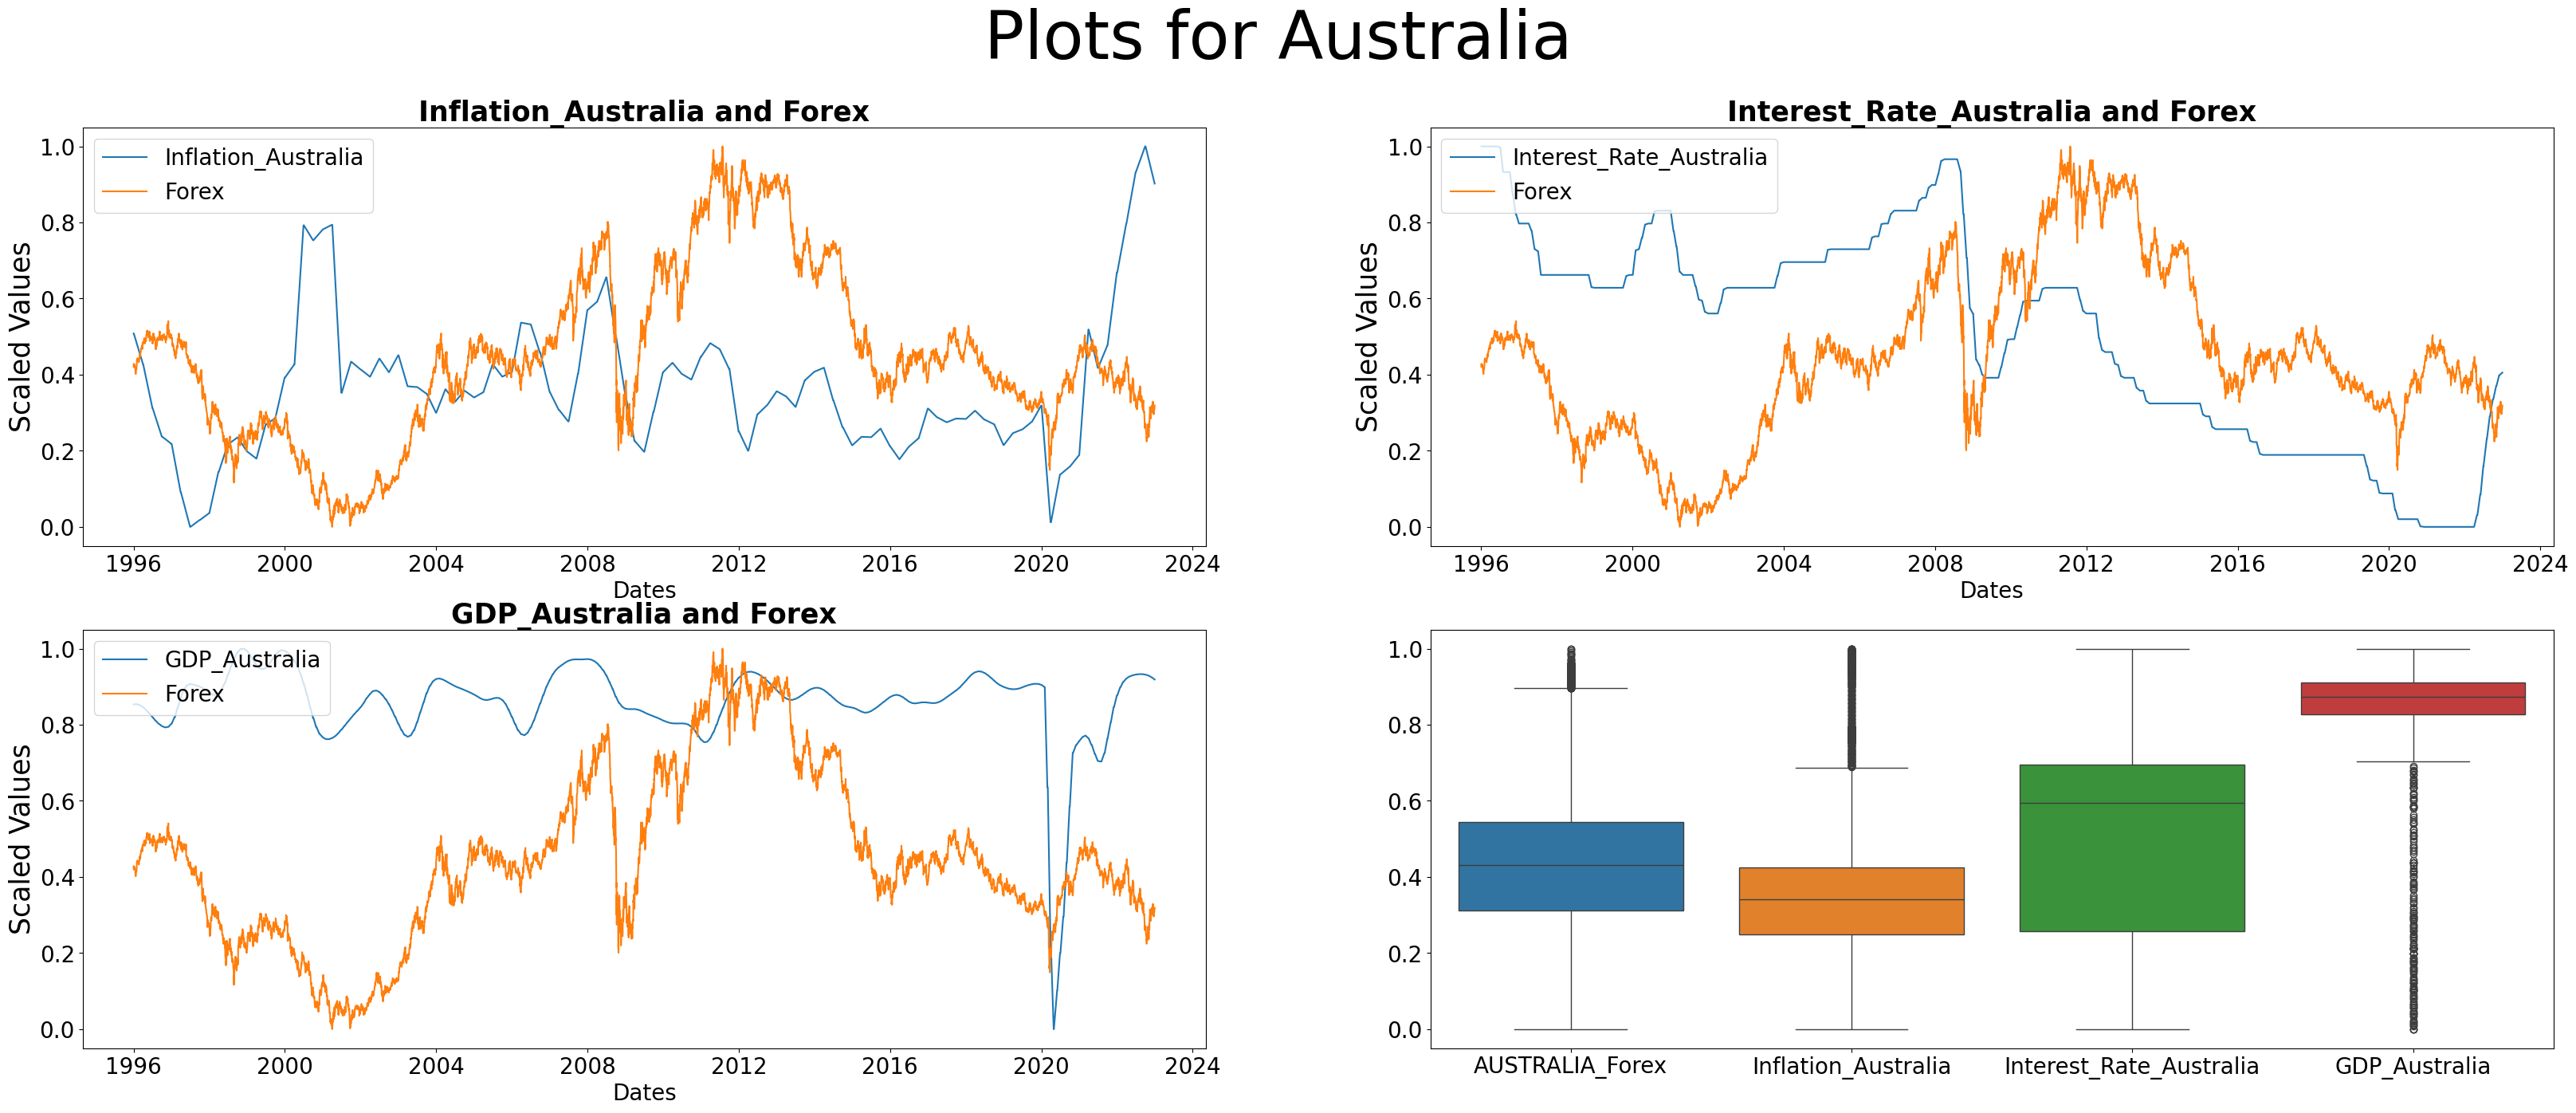

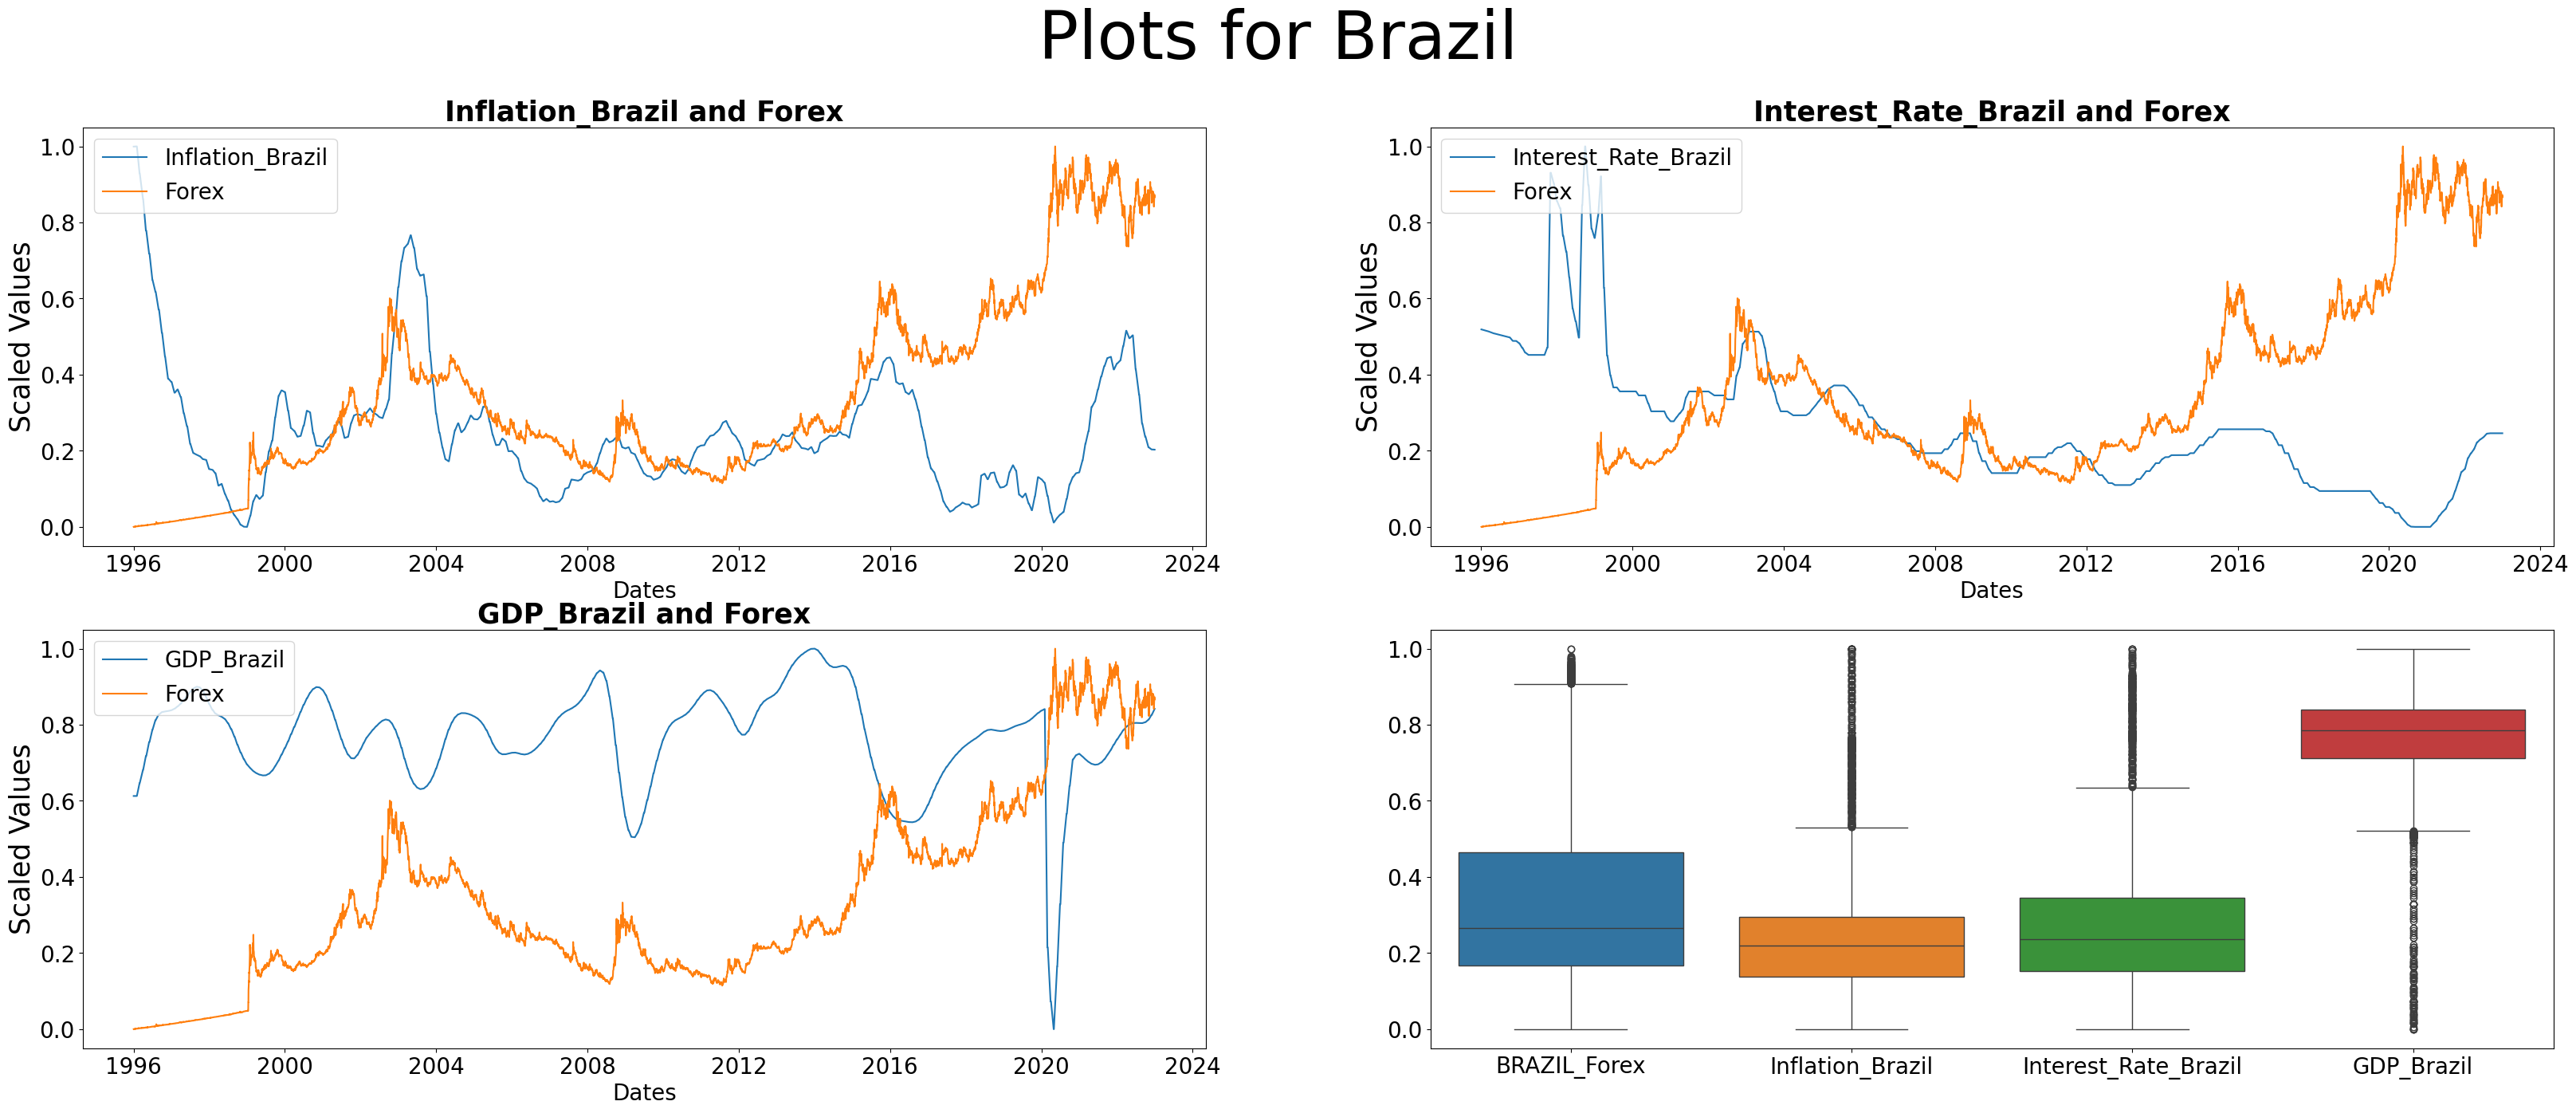

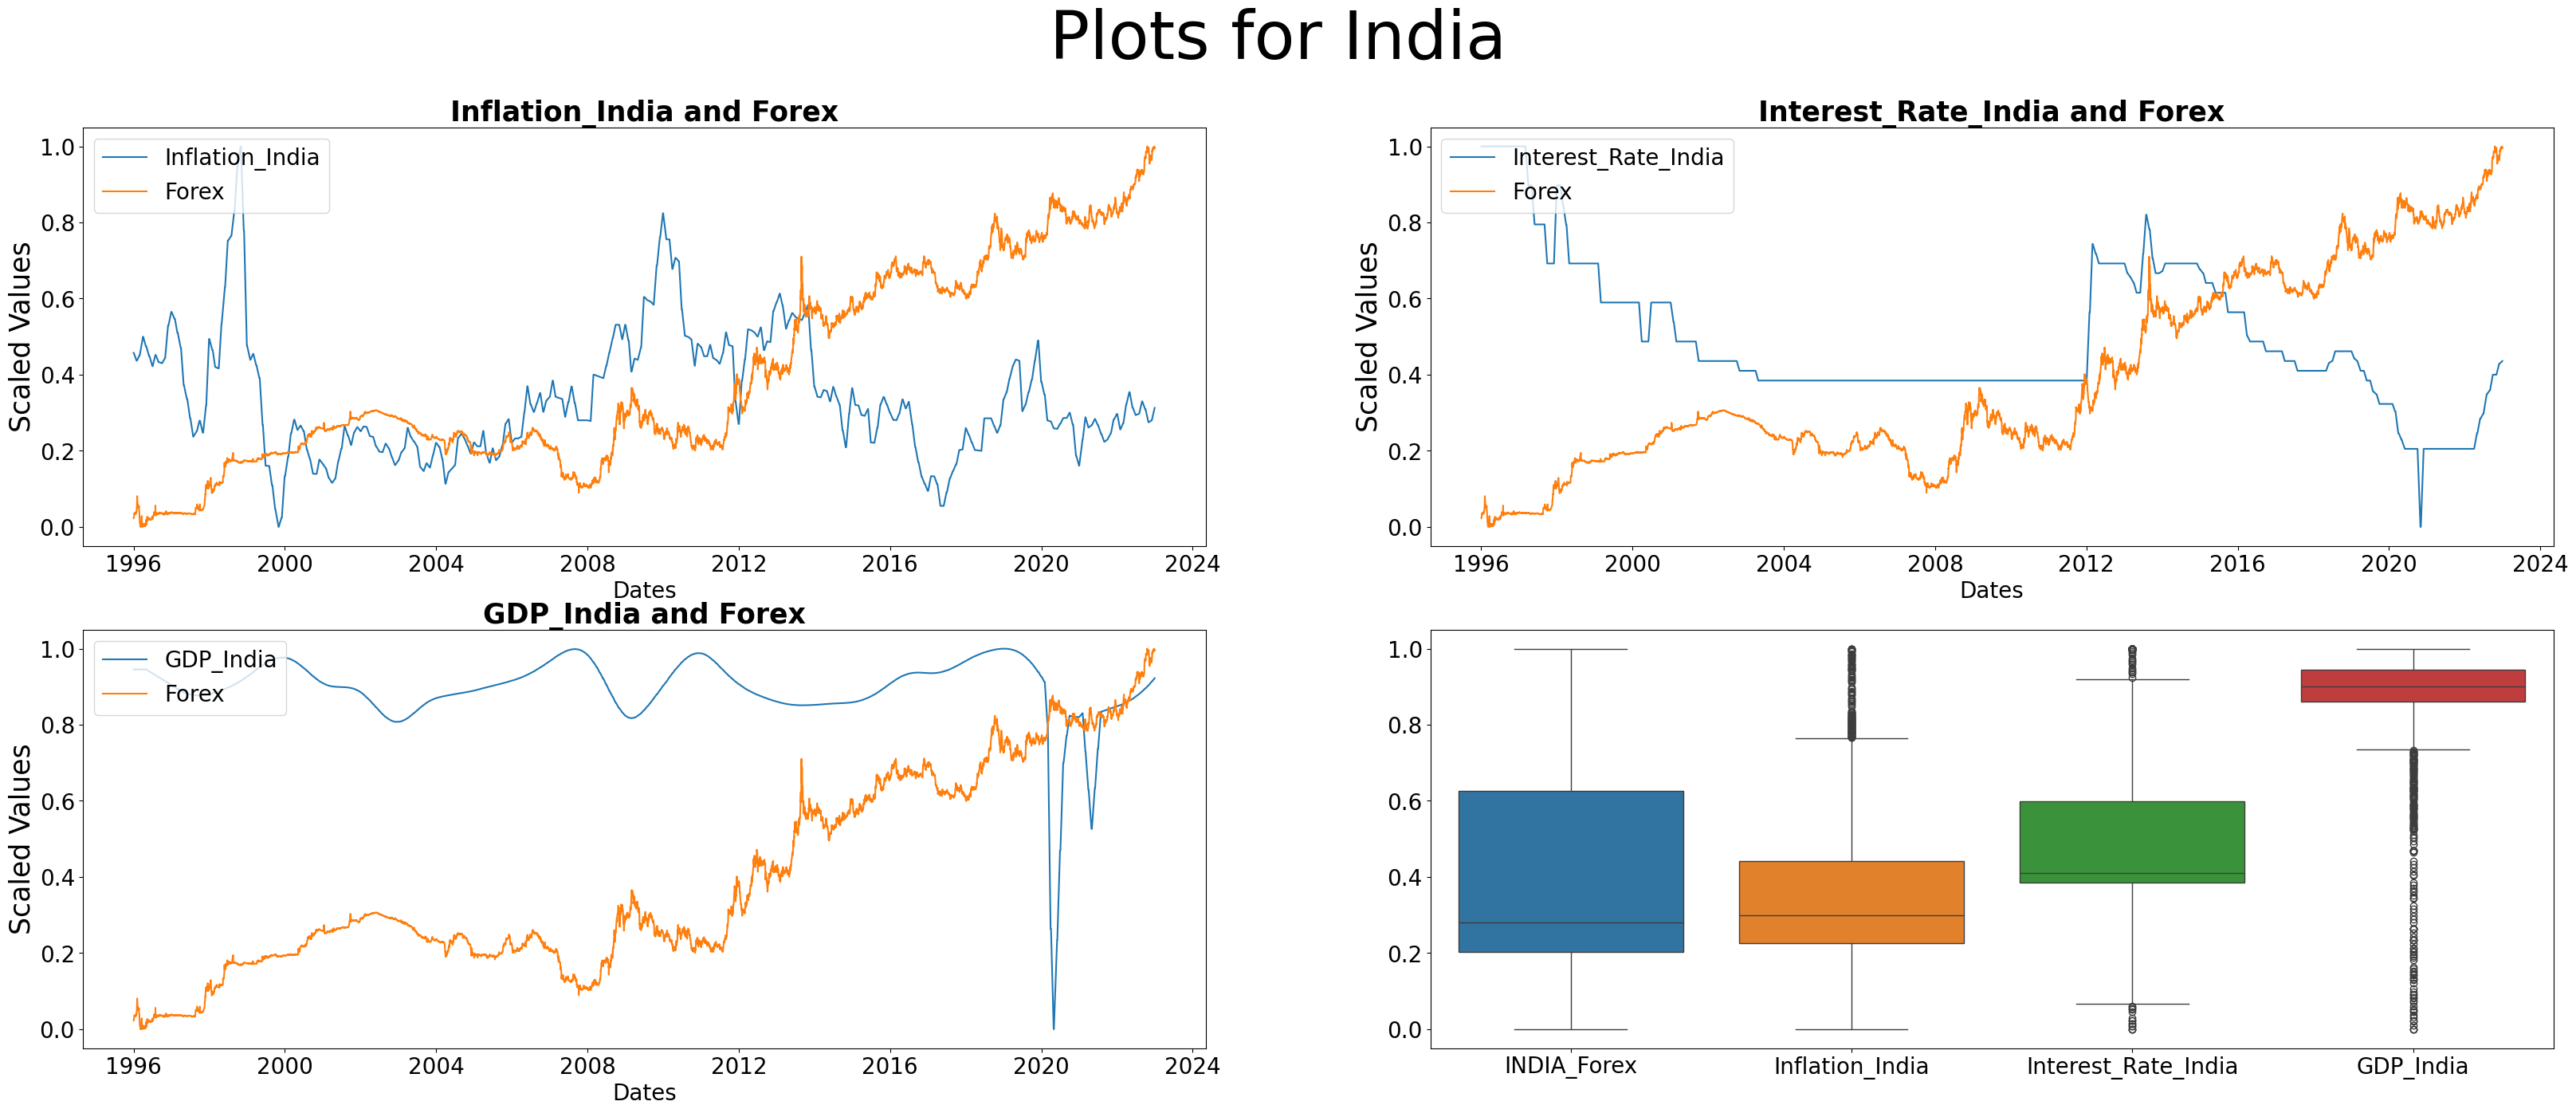

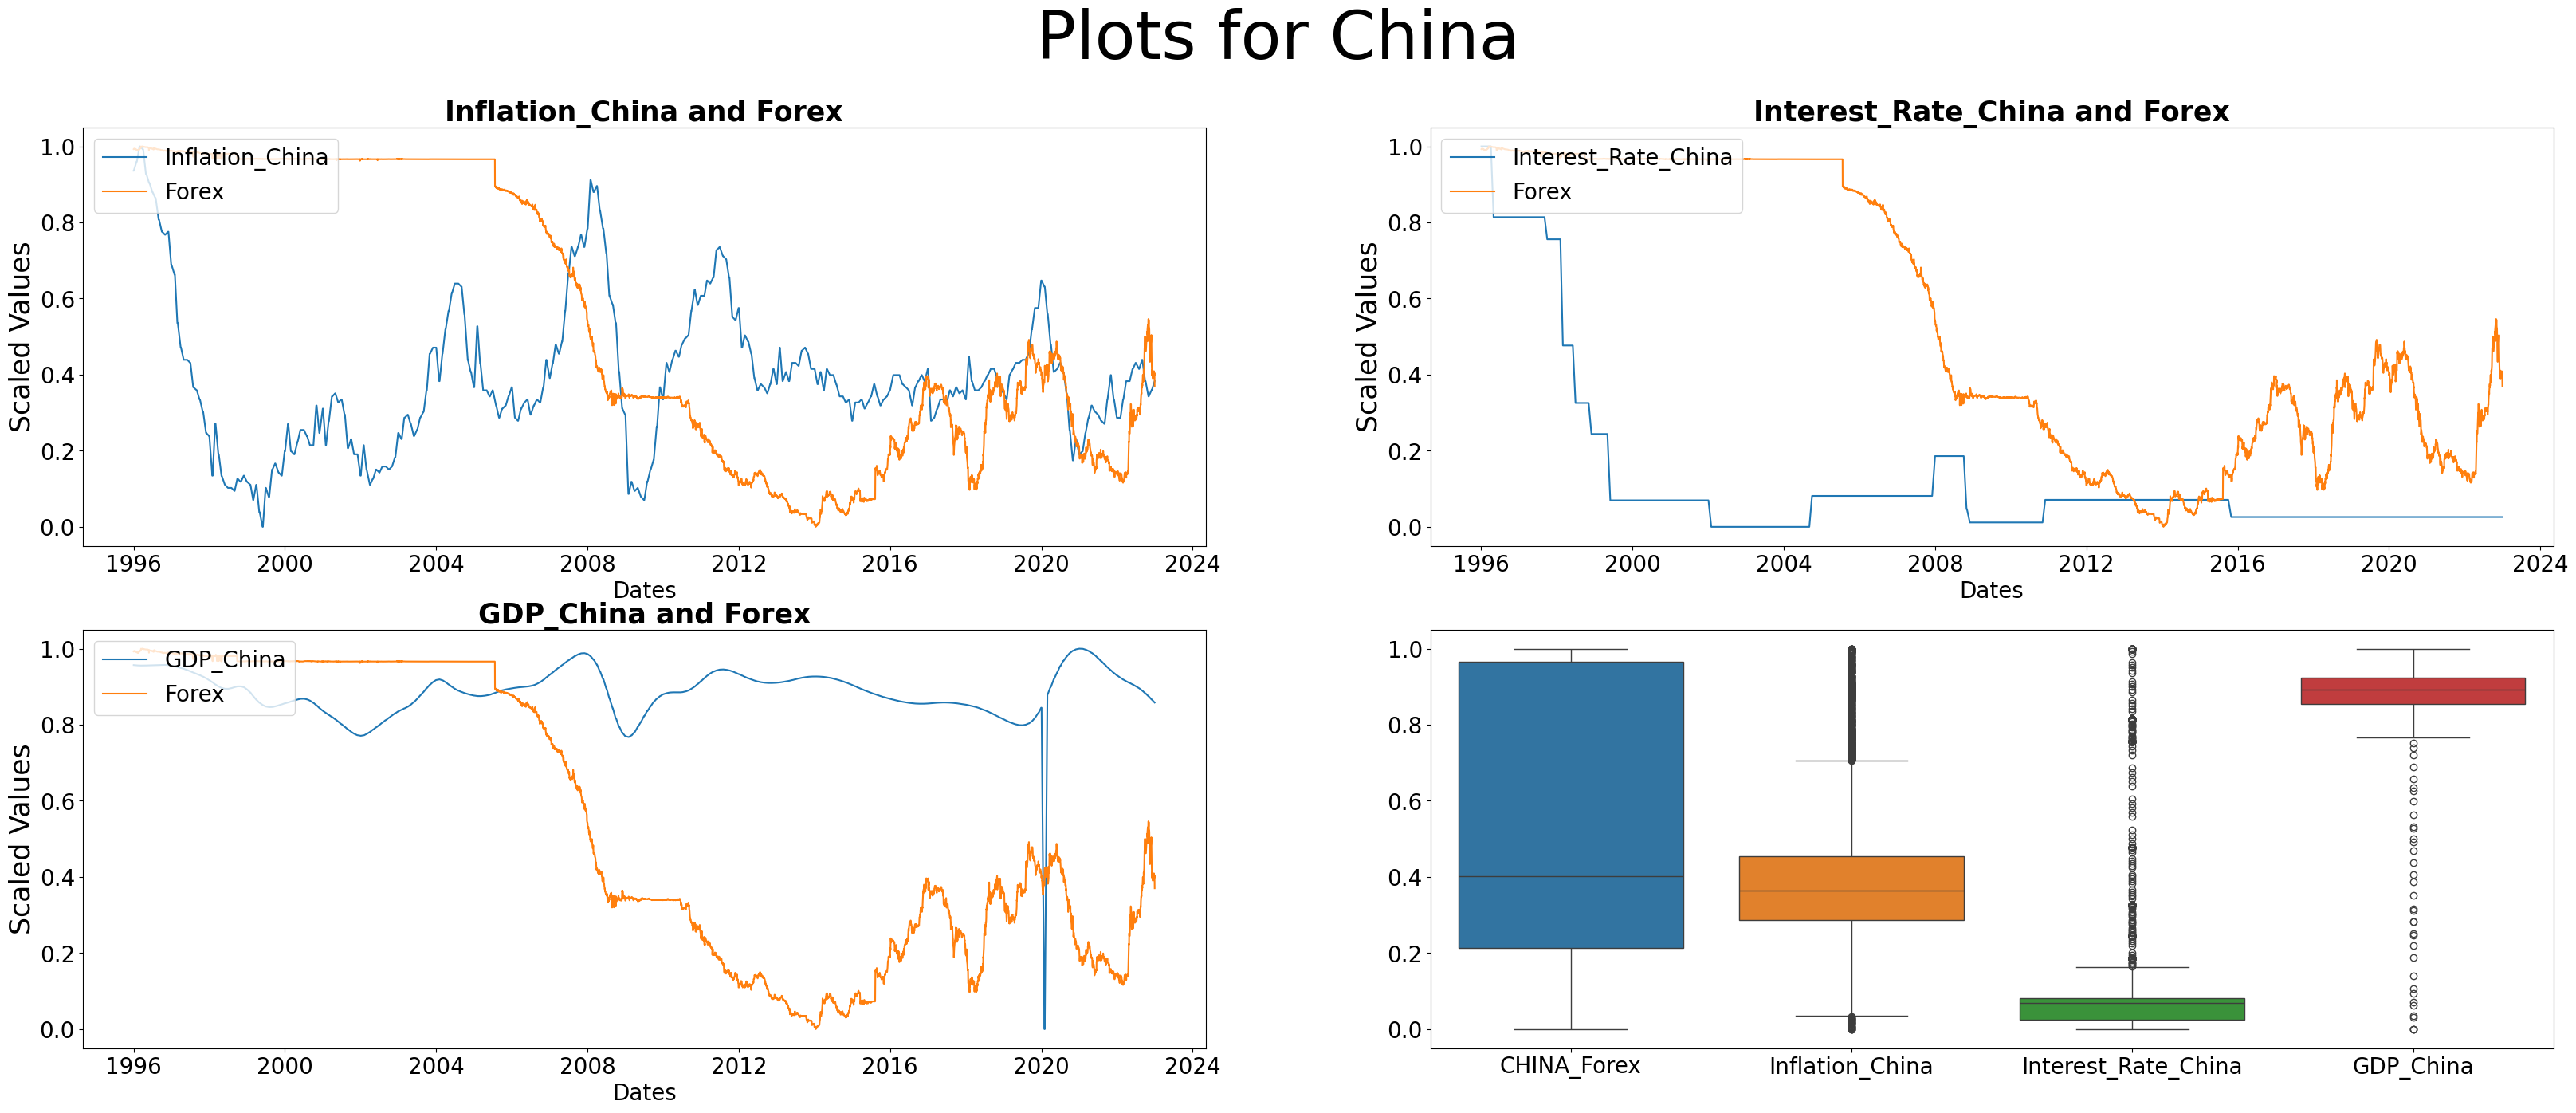

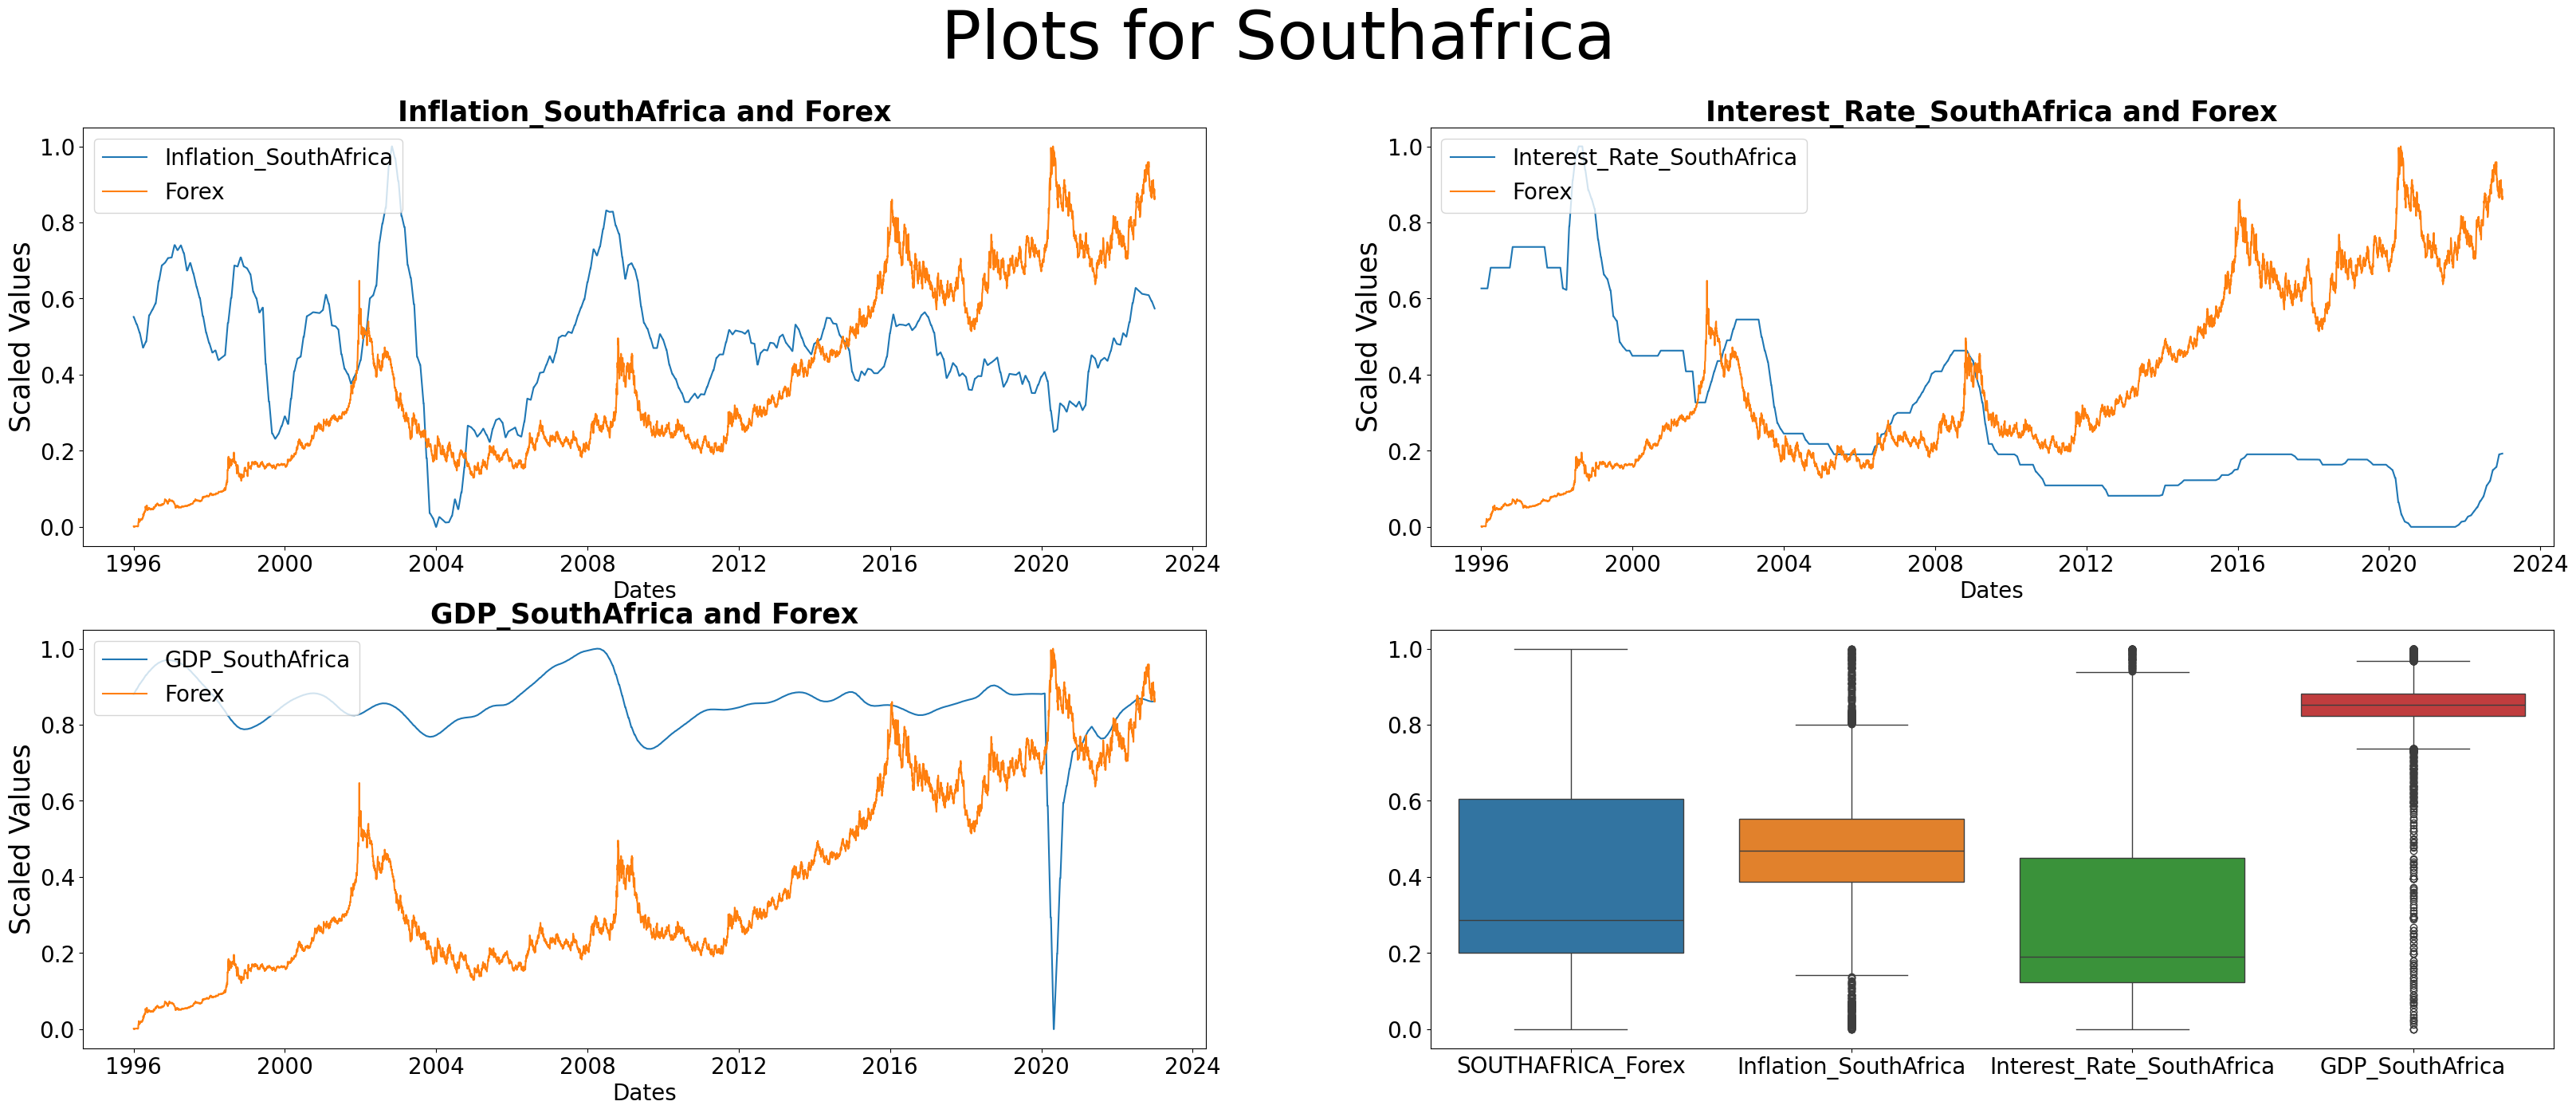

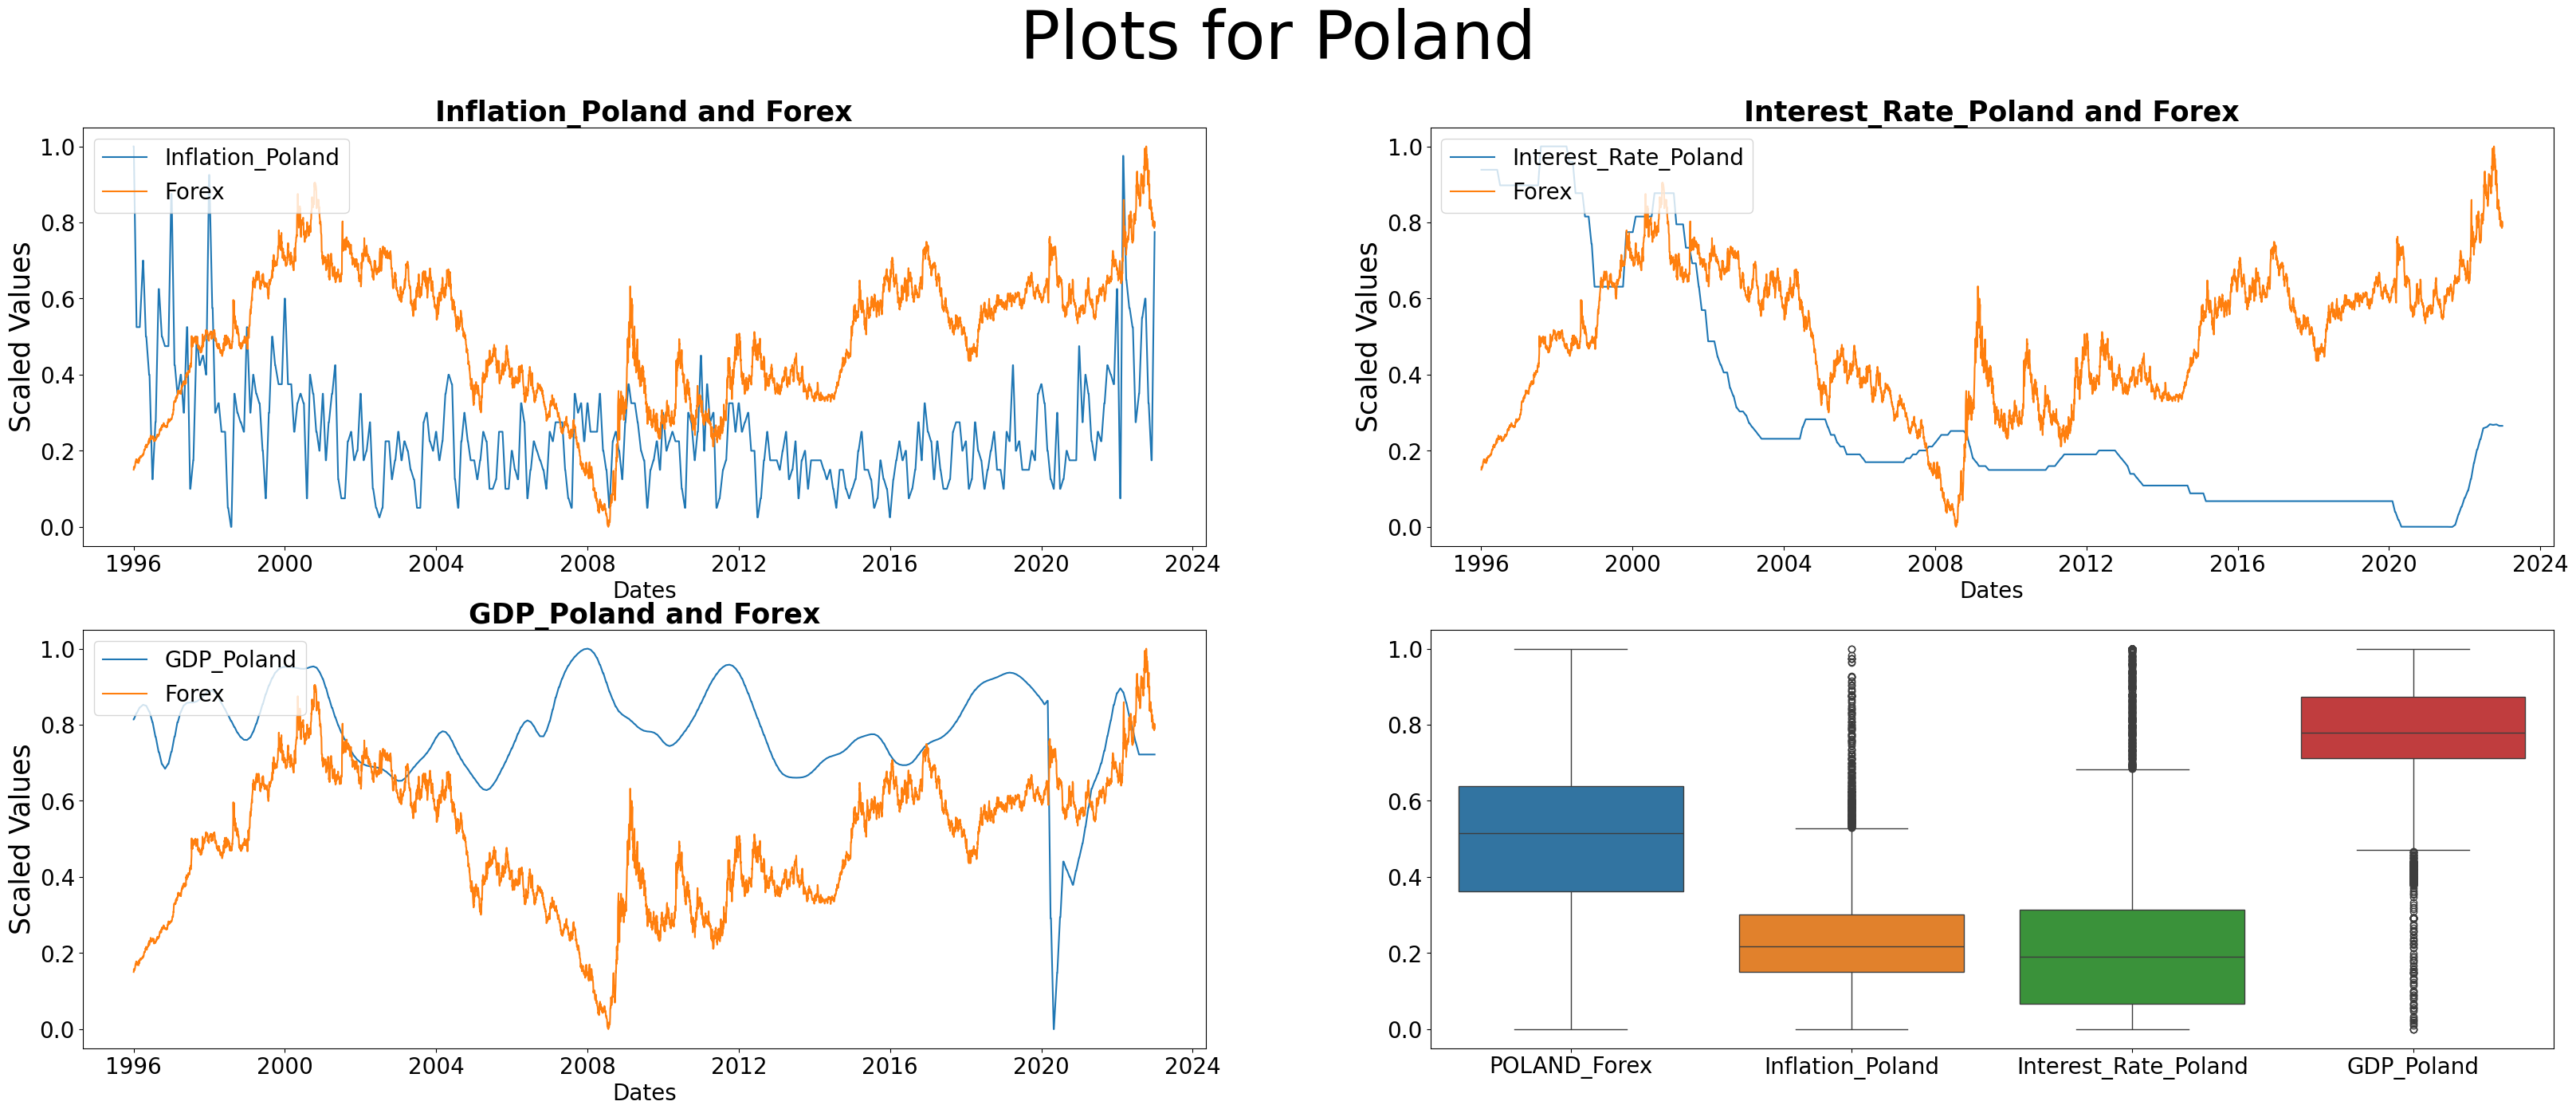

In [ ]:
for country in country_map:
    if country == 'usa':
        continue
    cols = [i for i in scaled_df.columns if country in i.lower()]
    forex_col = country.upper() + "_Forex"
    fig, axes = plt.subplots(2, 2, figsize=(40, 15))
    fig.suptitle(f'Plots for {country.capitalize()}', fontsize=60)
    for indx, i in enumerate(cols):
        #print(indx, i)
        if i == forex_col:
            continue
        if indx < 3:
            posi = [0,indx-1]
        else:
            posi = [1,0]
        #print(indx, posi)
        ax = axes[posi[0], posi[1]]
        ax.plot(scaled_df[i], label=i)
        ax.plot(scaled_df[forex_col], label = "Forex")
        ax.legend(loc="upper left", fontsize = 20)

        ax.tick_params(labelsize=20)
        ax.set_title(f'{i} and Forex',fontweight="bold", size=25) # Title
        ax.set_ylabel('Scaled Values', fontsize = 25) # Y label
        ax.set_xlabel('Dates', fontsize = 20) # X label
    #axes[1,1].boxplot(, labels=cols)
    axes[1,1].tick_params(labelsize=20)
    sns.boxplot( data=scaled_df[cols],  orient='v' , ax=axes[1,1])

# Models (Same for all formats)

In [7]:
def fit_rnn(train_X, train_Y, val_x, val_y, input_shape = None, epochs = 30, batch_size = 200):
    if not input_shape:
        input_shape = train_X.shape[1], train_X.shape[2]

    regressor = Sequential()

    regressor.add(SimpleRNN(units = 512,
                            activation = "tanh",
                            return_sequences = True,
                            input_shape = input_shape))

    regressor.add(SimpleRNN(units = 256,
                            activation = "tanh",
                            return_sequences = True))

    regressor.add(SimpleRNN(units = 256,
                            activation = "tanh",
                            return_sequences = True))

    regressor.add(SimpleRNN(units = 128,
                            activation = "tanh",
                            return_sequences = False))

    regressor.add(Dense(units = 1,activation='sigmoid'))

    regressor.compile(optimizer = SGD(learning_rate=0.01,
                                      momentum=0.9,
                                      nesterov=True),
                      loss = "mean_squared_error")

    history = regressor.fit(train_X, train_Y, epochs = epochs, batch_size = batch_size, validation_data=(val_x, val_y))

    return regressor, history


def fit_lstm(train_X, train_Y, val_x, val_y, input_shape = None, epochs = 30, batch_size = 200):
    if not input_shape:
        input_shape = train_X.shape[1], train_X.shape[2]

    regressor = Sequential()

    regressor.add(LSTM(units = 512,
                            activation = "tanh",
                            return_sequences = True,
                            input_shape = input_shape))

    regressor.add(LSTM(units = 256,
                            activation = "tanh",
                            return_sequences = True))

    regressor.add(LSTM(units = 256,
                            activation = "tanh",
                            return_sequences = True))

    regressor.add(LSTM(units = 128,
                            activation = "tanh",
                            return_sequences = False))

    regressor.add(Dense(units = 1,activation='sigmoid'))

    regressor.compile(optimizer = SGD(learning_rate=0.01,
                                      momentum=0.9,
                                      nesterov=True),
                      loss = "mean_squared_error")

    history = regressor.fit(train_X, train_Y, epochs = epochs, batch_size = batch_size, validation_data=(val_x, val_y))

    return regressor, history

def evaluate_model_performance(model, test_x, test_y, scaled_df, model_name, history=False):
    y_pred = model.predict(test_x, verbose=0)
    y_vals = scaled_df.iloc[-len(test_y):].index

    mae = metrics.mean_absolute_error(test_y, y_pred)
    mse = metrics.mean_squared_error(test_y, y_pred)
    r2 = metrics.r2_score(test_y, y_pred)

    print(f"The model performance for {model_name} Model on Test set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))

    plt.rcParams["figure.figsize"] = (15, 7)
    plt.plot(y_vals, test_y, color='red', label = "Actual")
    plt.plot(y_vals, y_pred, color="blue", label = "Predicted")
    plt.legend(loc="upper left", fontsize = 15)
    #plt.yscale()
    plt.title(f"India Forex Actual vs Predicted ({model_name} Model)",fontweight="bold", size=15) # Title
    plt.ylabel('Scaled Values', fontsize = 10) # Y label
    plt.xlabel('Dates', fontsize = 10) #
    plt.show()

    if not history:
        return
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f' {model_name} Model Loss', fontweight="bold", size=15)
    plt.ylabel('Loss', fontsize = 10)
    plt.xlabel('Epoch', fontsize = 10)
    plt.legend(['Train', 'Validation'], loc='upper left', fontsize = 15)
    plt.show()


# 1. Base Line Model

## Data Formatting

In [8]:
seq_len = 30
data_X, data_Y = [], []
for index, row in final_df.iterrows():
    if index < seq_len:
        continue
    rows = final_df[index - seq_len : index]
    data_X.append(rows.to_numpy().flatten())
    data_Y.append(row['INDIA_Forex'])


In [9]:

train_break = round(len(data_X) * 0.7)
val_break = round(len(data_X) * 0.8)

train_X, train_Y = data_X[:train_break], data_Y[:train_break]
val_X, val_Y = data_X[train_break:val_break], data_Y[train_break:val_break]
test_x, test_y = data_X[val_break:], data_Y[val_break:]

train_X = np.array(train_X)
train_Y = np.array(train_Y)
val_X = np.array(val_X)
val_Y = np.array(val_Y)
test_x = np.array(test_x)
test_y = np.array(test_y)

train_X, train_Y = shuffle(train_X, train_Y)

train_X = np.reshape(train_X, [train_X.shape[0], seq_len, final_df.shape[1]])
train_Y = np.reshape(train_Y, [train_Y.shape[0], 1])
val_X = np.reshape(val_X, [val_X.shape[0], seq_len, final_df.shape[1]])
val_Y = np.reshape(val_Y, [val_Y.shape[0], 1])
test_x = np.reshape(test_x, [test_x.shape[0], seq_len, final_df.shape[1]])
test_y = np.reshape(test_y, [test_y.shape[0], 1])

## RNN Model Fitting & Evaluation

In [ ]:
rnn_model, rnn_history = fit_rnn(train_X, train_Y, val_X, val_Y)

Epoch 1/30
25/25 [==============================] - 13s 302ms/step - loss: 0.0194 - val_loss: 0.0314
Epoch 2/30
25/25 [==============================] - 7s 270ms/step - loss: 0.0036 - val_loss: 0.0241
Epoch 3/30
25/25 [==============================] - 7s 261ms/step - loss: 0.0016 - val_loss: 0.0203
Epoch 4/30
25/25 [==============================] - 6s 256ms/step - loss: 0.0011 - val_loss: 0.0121
Epoch 5/30
25/25 [==============================] - 7s 267ms/step - loss: 5.5933e-04 - val_loss: 0.0134
Epoch 6/30
25/25 [==============================] - 7s 267ms/step - loss: 5.3945e-04 - val_loss: 0.0218
Epoch 7/30
25/25 [==============================] - 6s 255ms/step - loss: 5.1265e-04 - val_loss: 0.0153
Epoch 8/30
25/25 [==============================] - 7s 261ms/step - loss: 3.7771e-04 - val_loss: 0.0151
Epoch 9/30
25/25 [==============================] - 7s 263ms/step - loss: 5.4485e-04 - val_loss: 0.0141
Epoch 10/30
25/25 [==============================] - 6s 255ms/step - loss: 3.36

In [ ]:
test_x.shape

(1403, 30, 28)

The model performance for Baseline RNN Model on Test set
--------------------------------------
MAE is 0.20864838361740112
MSE is 0.04839542880654335
R2 score is -4.734391272122265


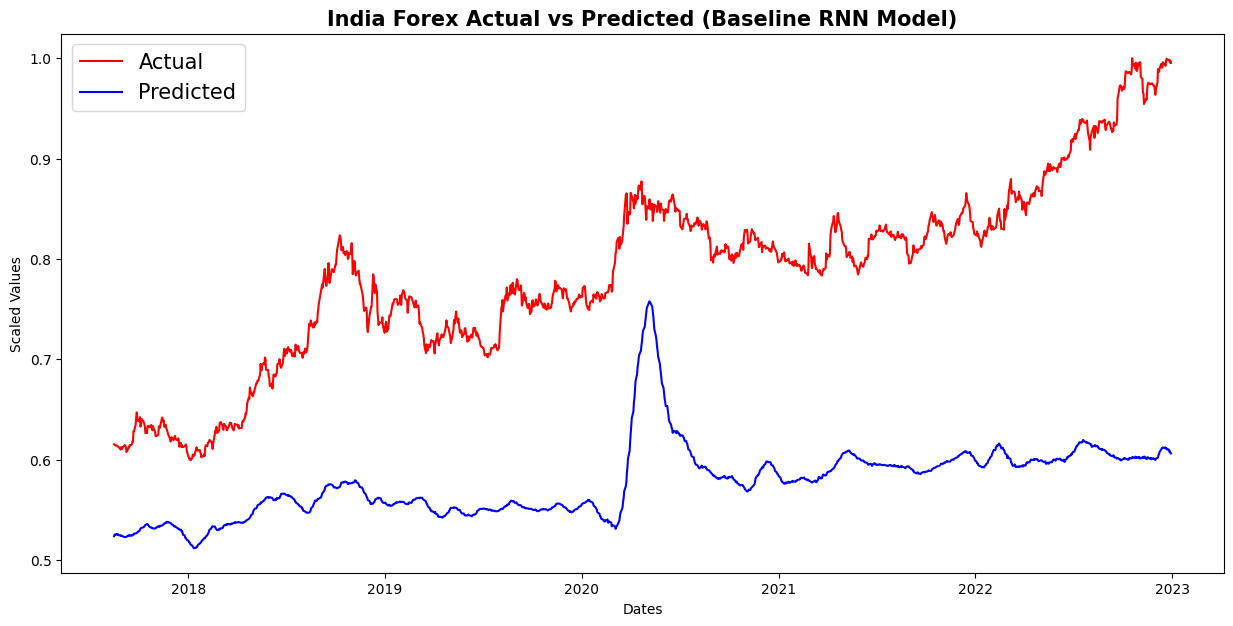

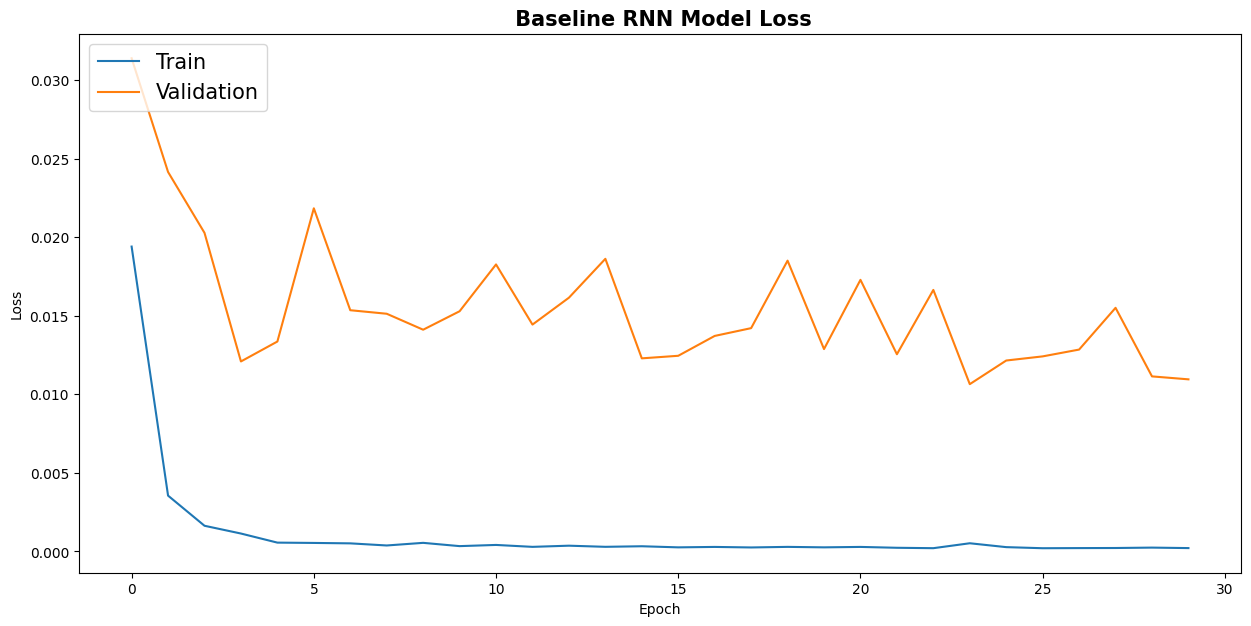

In [ ]:
evaluate_model_performance(rnn_model, test_x, test_y, scaled_df, "Baseline RNN", rnn_history)

## LSTM model Fitting and Evaluation

In [ ]:
lstm_model, lstm_history = fit_lstm(train_X, train_Y, val_X, val_Y)

Epoch 1/30
25/25 [==============================] - 23s 337ms/step - loss: 0.0339 - val_loss: 0.1816
Epoch 2/30
25/25 [==============================] - 6s 231ms/step - loss: 0.0145 - val_loss: 0.1273
Epoch 3/30
25/25 [==============================] - 6s 231ms/step - loss: 0.0123 - val_loss: 0.1212
Epoch 4/30
25/25 [==============================] - 6s 232ms/step - loss: 0.0106 - val_loss: 0.1028
Epoch 5/30
25/25 [==============================] - 6s 232ms/step - loss: 0.0086 - val_loss: 0.0850
Epoch 6/30
25/25 [==============================] - 6s 231ms/step - loss: 0.0065 - val_loss: 0.0643
Epoch 7/30
25/25 [==============================] - 6s 232ms/step - loss: 0.0050 - val_loss: 0.0467
Epoch 8/30
25/25 [==============================] - 6s 231ms/step - loss: 0.0041 - val_loss: 0.0344
Epoch 9/30
25/25 [==============================] - 6s 231ms/step - loss: 0.0035 - val_loss: 0.0261
Epoch 10/30
25/25 [==============================] - 6s 232ms/step - loss: 0.0030 - val_loss: 0.020

The model performance for Baseline LSTM Model on Test set
--------------------------------------
MAE is 0.14973744750022888
MSE is 0.026003483682870865
R2 score is -2.081161923470445


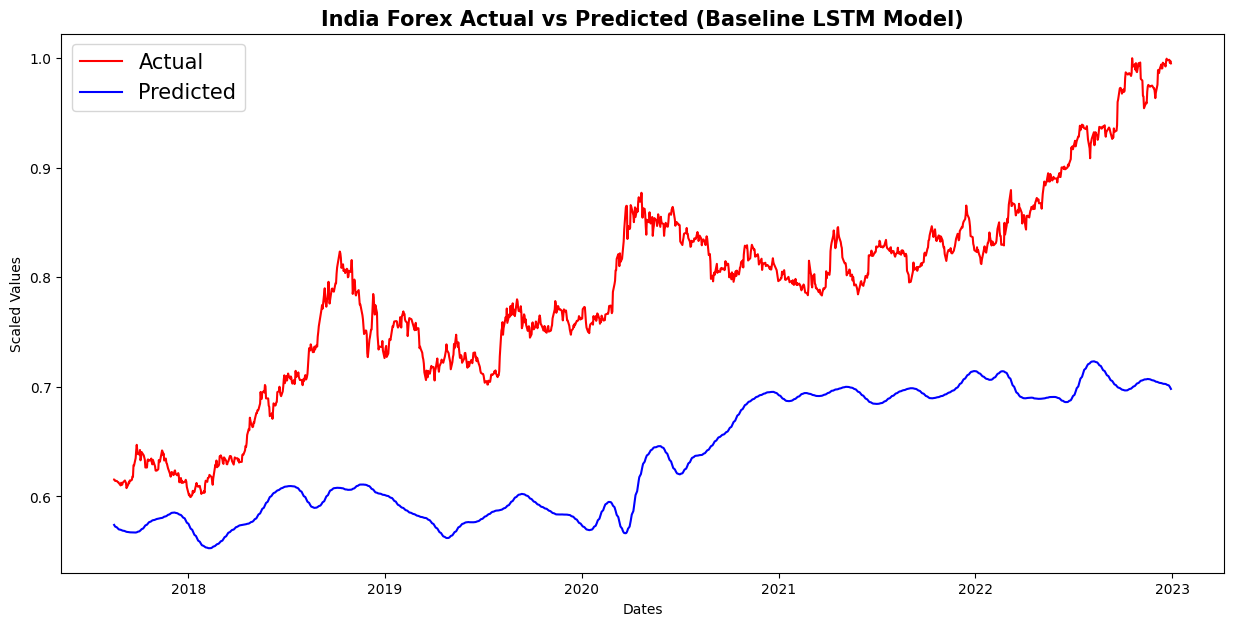

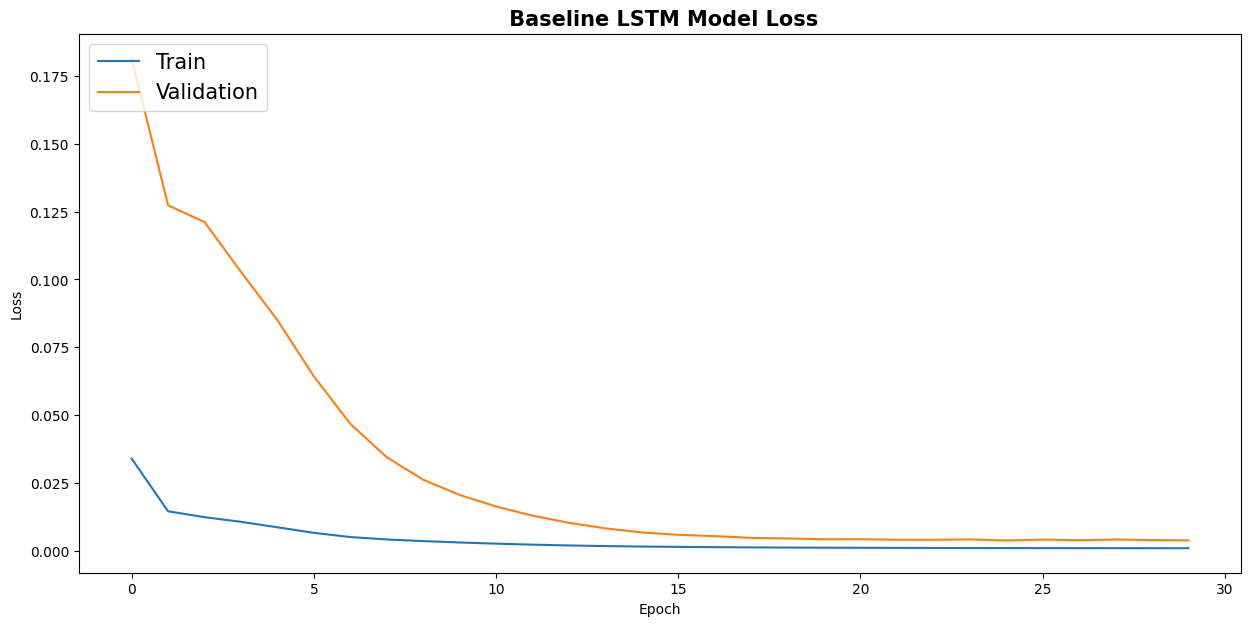

In [ ]:
evaluate_model_performance(lstm_model, test_x, test_y, scaled_df, "Baseline LSTM", lstm_history)

# 2. Using Pretrained Models and Fine Tuning

In [10]:
def create_formatted_train_test(data_X, data_Y):
    train_break = round(len(data_X) * 0.7)
    val_break = round(len(data_X) * 0.8)

    train_X, train_Y = data_X[:train_break], data_Y[:train_break]
    val_X, val_Y = data_X[train_break:val_break], data_Y[train_break:val_break]
    test_x, test_y = data_X[val_break:], data_Y[val_break:]

    train_X = np.array(train_X)
    train_Y = np.array(train_Y)
    val_X = np.array(val_X)
    val_Y = np.array(val_Y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)

    train_X, train_Y = shuffle(train_X, train_Y)

    train_X = np.reshape(train_X, [train_X.shape[0], seq_len, 5])
    train_Y = np.reshape(train_Y, [train_Y.shape[0], 1])
    val_X = np.reshape(val_X, [val_X.shape[0], seq_len, 5])
    val_Y = np.reshape(val_Y, [val_Y.shape[0], 1])
    test_x = np.reshape(test_x, [test_x.shape[0], seq_len, 5])
    test_y = np.reshape(test_y, [test_y.shape[0], 1])
    return train_X, train_Y, val_X, val_Y, test_x, test_y

def get_india_data(data_x, data_y):
    indexes = data_x[:, :, 4] == 6
    data_x = data_x[indexes]
    data_y = data_y[indexes[:,0]==True]
    data_ind_x = np.reshape(data_x, [data_x.shape[0]//seq_len, seq_len, 5])
    data_ind_y = np.reshape(data_y, [data_y.shape[0], 1])
    return data_ind_x, data_ind_y

def remove_india_data(data_x, data_y, percentage):
    indexes = data_x[:, :, 4] != 6
    new_data_x = data_x[indexes]
    new_data_y = data_y[indexes[:,0]==True]
    new_data_x = np.reshape(new_data_x, [new_data_x.shape[0]//30, seq_len, 5])
    new_data_y = np.reshape(new_data_y, [new_data_y.shape[0], 1])

    if percentage == 1:
        return new_data_x, new_data_y

    indexes = data_x[:, :, 4] == 6
    ind_data_x = data_x[indexes]
    ind_data_y = data_y[indexes[:,0]==True]
    ind_data_x = np.reshape(ind_data_x, [ind_data_x.shape[0]//30, seq_len, 5])
    ind_data_y = np.reshape(ind_data_y, [ind_data_y.shape[0], 1])

    del_indexes = random.sample(range(0, ind_data_x.shape[0]), int(ind_data_x.shape[0] * percentage))
    ind_data_x = np.delete(ind_data_x, del_indexes, axis=0)
    ind_data_y = np.delete(ind_data_y, del_indexes, axis=0)

    new_data_x = np.concatenate([ind_data_x,new_data_x])
    new_data_y = np.concatenate([ind_data_y,new_data_y])
    new_data_x, new_data_y = shuffle(new_data_x, new_data_y)
    return new_data_x, new_data_y

def generate_data_for_pretrain(final_df, seq_len, pretrain_method):
    data_X, data_Y = [], []
    country_map = ["australia", "brazil", "china", "usa", "southafrica", "poland", "india"]
    for index, row in final_df.iterrows():
        if index < seq_len:
            continue
        if index % 1000 == 0:
            print(index, end = '\t')
        rows = final_df[index - seq_len : index]
        for country in country_map:
            cols = [i for i in rows.columns if country in i.lower()]
            current_rows = rows[cols].copy()
            current_rows['Country_Code'] = country_map.index(country)

            data_X.append(current_rows.to_numpy().flatten())
            data_Y.append(row[f'{country.upper()}_Forex'])

    train_X, train_Y, val_X, val_Y, test_x, test_y = create_formatted_train_test(data_X, data_Y)

    if pretrain_method == 1:
        fine_tune_train_X, fine_tune_train_Y = get_india_data(train_X, train_Y)
        fine_tune_val_X, fine_tune_val_Y = get_india_data(val_X, val_Y)
        fine_tune_test_X, fine_tune_test_Y = get_india_data(test_x, test_y)
    else:
        if pretrain_method == 2:
            remove_percent = 0.5
        elif pretrain_method == 3:
            remove_percent = 1
        new_train_X, new_train_Y = remove_india_data(train_X, train_Y, remove_percent)
        fine_tune_train_X, fine_tune_train_Y = get_india_data(train_X, train_Y)
        fine_tune_val_X, fine_tune_val_Y = get_india_data(val_X, val_Y)
        fine_tune_test_X, fine_tune_test_Y = get_india_data(test_x, test_y)
        train_X, train_Y =  new_train_X, new_train_Y

    return train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y

def fine_tune_model(model, train_X, train_Y, val_X, val_Y, model_type, epochs = 70, batch_size = 200):
    model.pop()
    model.pop()
    for layer in model.layers:
        layer.trainable = False

    if model_type == "rnn":
        model.add(SimpleRNN(units = 128,
                            activation = "tanh",
                            return_sequences = False))

        model.add(Dense(units = 1,activation='sigmoid'))
    elif model_type == "lstm":

        model.add(LSTM(units = 128,
                            activation = "tanh",
                            return_sequences = False))

        model.add(Dense(units = 1,activation='sigmoid'))
    print(model.summary())
    model.compile(optimizer = SGD(learning_rate=0.01,
                                      momentum=0.9,
                                      nesterov=True),
                      loss = "mean_squared_error")

    history = model.fit(train_X, train_Y, epochs = epochs, batch_size = batch_size, validation_data=(val_X, val_Y))
    return model, history


def generate_pretrain_finetune_evaluate_rnn(train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y,  model_type):
    rnn_model_pre1, rnn_pre1_history = fit_rnn(train_X, train_Y, val_X, val_Y)
    clear_output()
    fine_rnn1, fine_rnn1_hist = fine_tune_model(rnn_model_pre1, fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, fine_tune_val_Y, "rnn")
    evaluate_model_performance(fine_rnn1,  fine_tune_test_X, fine_tune_test_Y, scaled_df, model_type, fine_rnn1_hist)
    return rnn_model_pre1

def generate_pretrain_finetune_evaluate_lstm(train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y,  model_type):
    lstm_model_pre1, lstm_pre1_history = fit_lstm(train_X, train_Y, val_X, val_Y)
    clear_output()
    fine_lstm1, fine_lstm1_hist = fine_tune_model(lstm_model_pre1, fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, fine_tune_val_Y, "lstm")
    evaluate_model_performance(fine_lstm1,  fine_tune_test_X, fine_tune_test_Y, scaled_df, model_type, fine_lstm1_hist)
    return lstm_model_pre1

## Method 1
###  Using India's data in Pre-Training and again using the same data in Fine Tuning

In [ ]:
train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y = generate_data_for_pretrain(final_df, 30, 1)

1000	2000	3000	4000	5000	6000	7000	

### Generating Pretrained Model, FineTuning and Evaluating RNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 30, 512)           265216    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 30, 256)           196864    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 30, 256)           131328    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 642,817
Trainable params: 49,409
Non-trainable params: 593,408
_________________________________________________________________
None
Epoch 1/70
25/25 [==============================] - 10s 194ms/step - loss: 0.0182 - val_loss: 0.0458
Epo

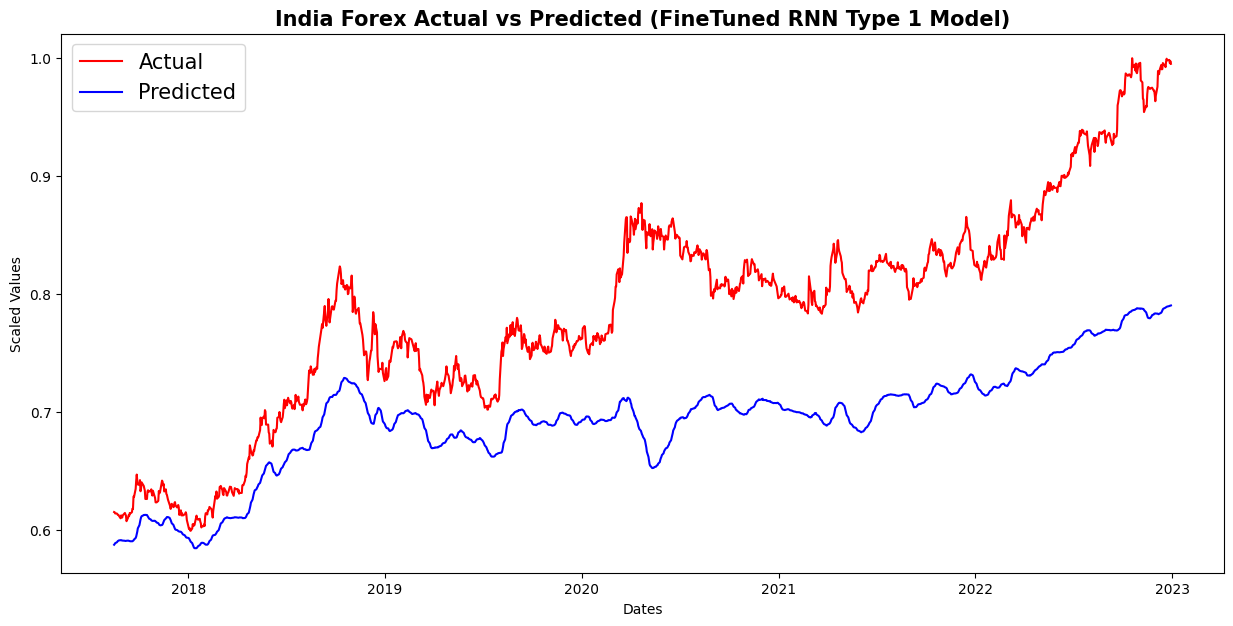

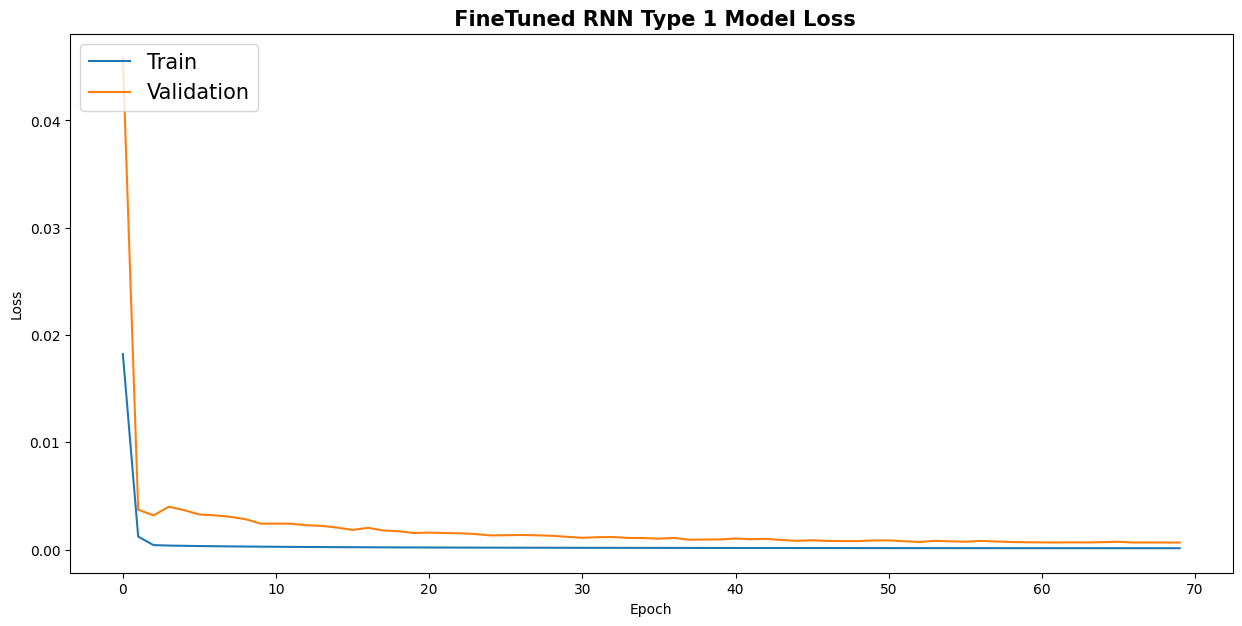

In [ ]:
rnn_pre_1 = generate_pretrain_finetune_evaluate_rnn(train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y, "FineTuned RNN Type 1")

### Generating Pretrained Model, FineTuning and Evaluating LSTM

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 512)           1060864   
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 256)           787456    
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 2,570,881
Trainable params: 197,249
Non-trainable params: 2,373,632
_________________________________________________________________
None
Epoch 1/70
25/25 [==============================] - 17s 222ms/step - loss: 0.0372 - val_loss: 0.196

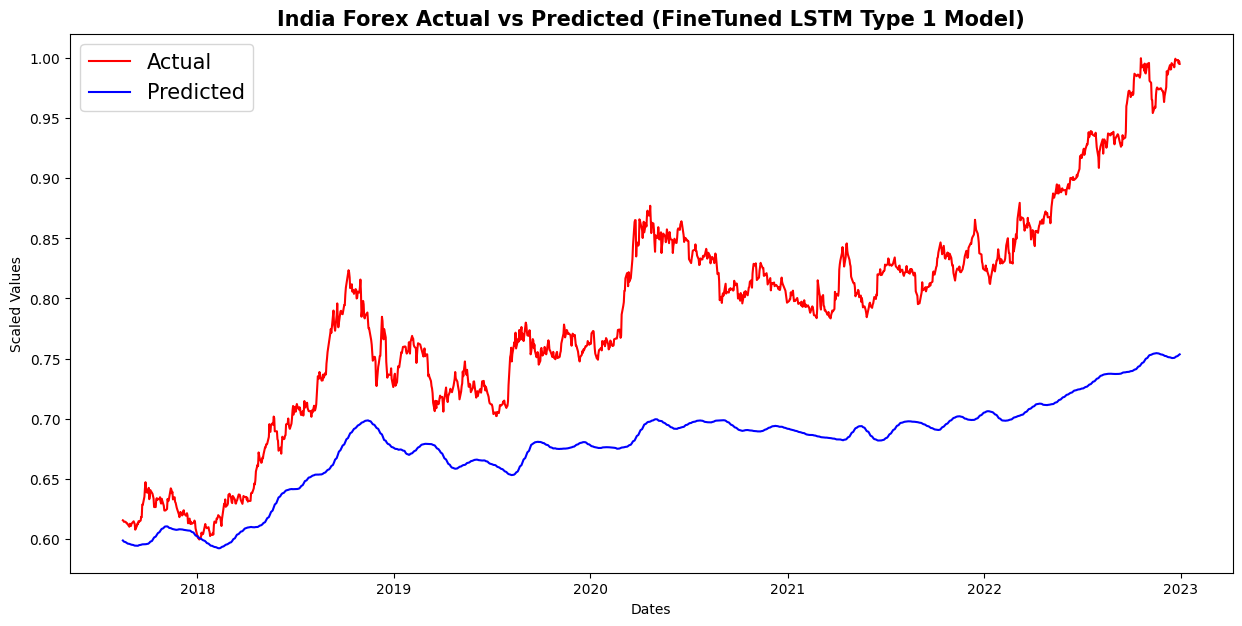

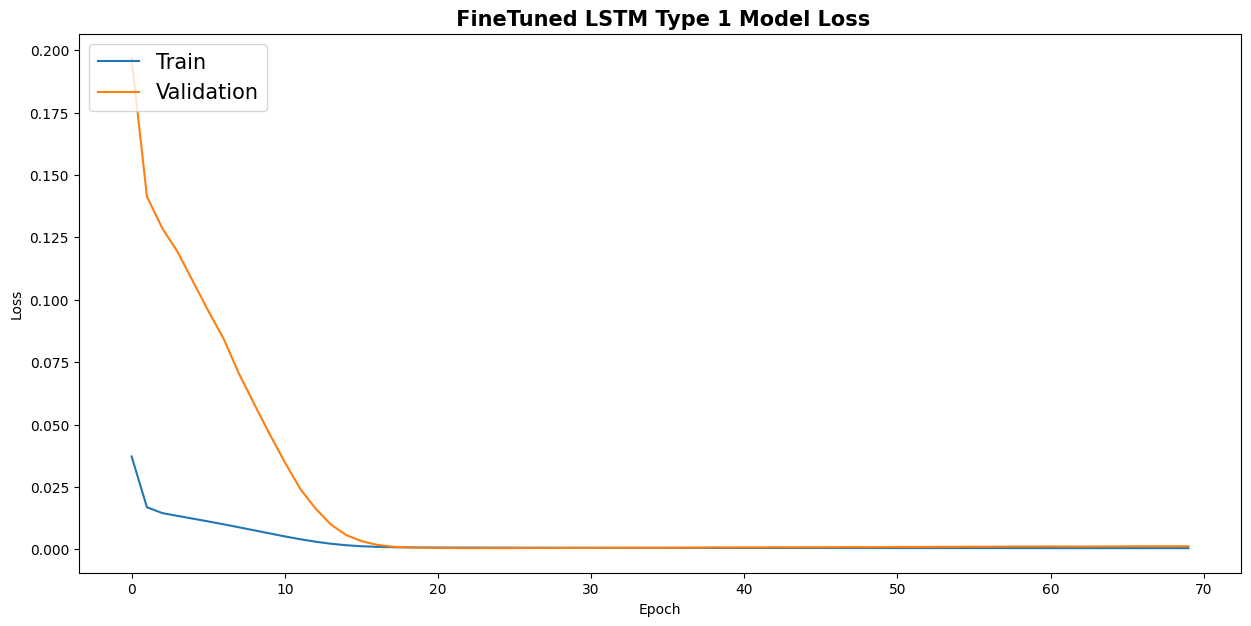

In [ ]:
lstm_pre_1 = generate_pretrain_finetune_evaluate_lstm(train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y,  "FineTuned LSTM Type 1")

## Method 2
###  Using Only some India's data in Pre-Training and again using complete India's data in Fine Tuning

In [ ]:
train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y = generate_data_for_pretrain(final_df, 30, 2)

1000	2000	3000	4000	5000	6000	7000	

### Generating Pretrained Model, FineTuning and Evaluating RNN

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 30, 512)           265216    
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 30, 256)           196864    
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 30, 256)           131328    
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 128)               49280     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 642,817
Trainable params: 49,409
Non-trainable params: 593,408
_________________________________________________________________
None
Epoch 1/70
25/25 [==============================] - 10s 232ms/step - loss: 0.0178 - val_loss: 0.0511
Epo

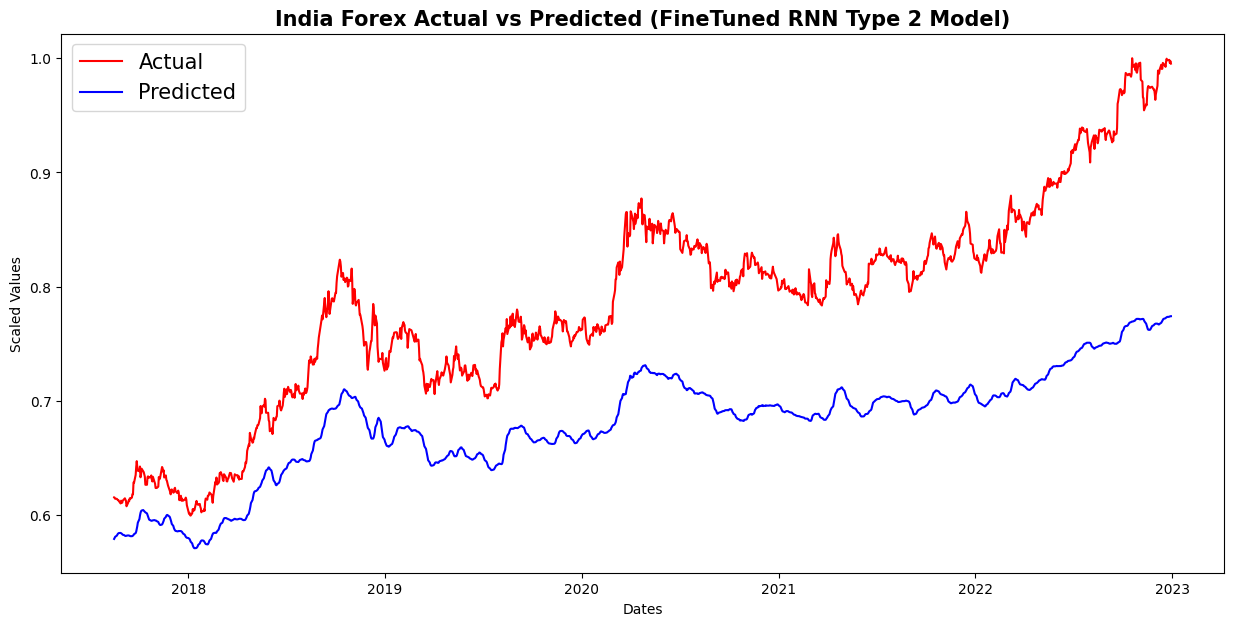

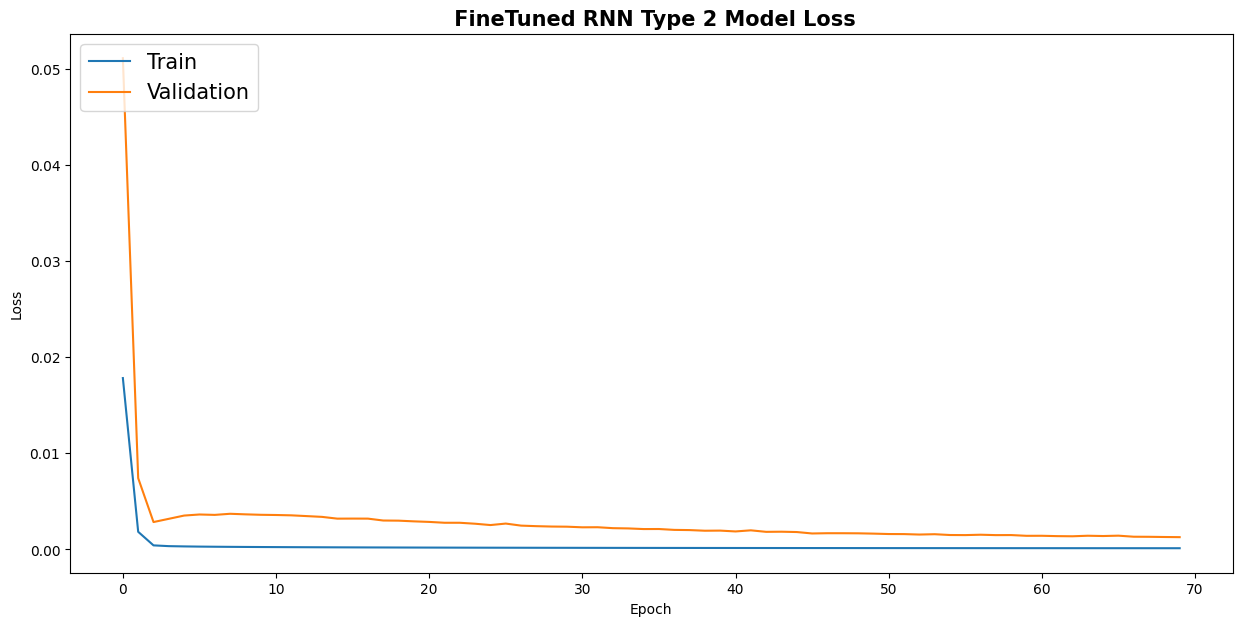

In [ ]:
rnn_pre_2 = generate_pretrain_finetune_evaluate_rnn(train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y, "FineTuned RNN Type 2")

### Generating Pretrained Model, FineTuning and Evaluating LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 512)           1060864   
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 256)           787456    
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 256)           525312    
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 2,570,881
Trainable params: 197,249
Non-trainable params: 2,373,632
_________________________________________________________________
None
Epoch 1/70
25/25 [==============================] - 17s 215ms/step - loss: 0.0274 - val_loss: 0.180

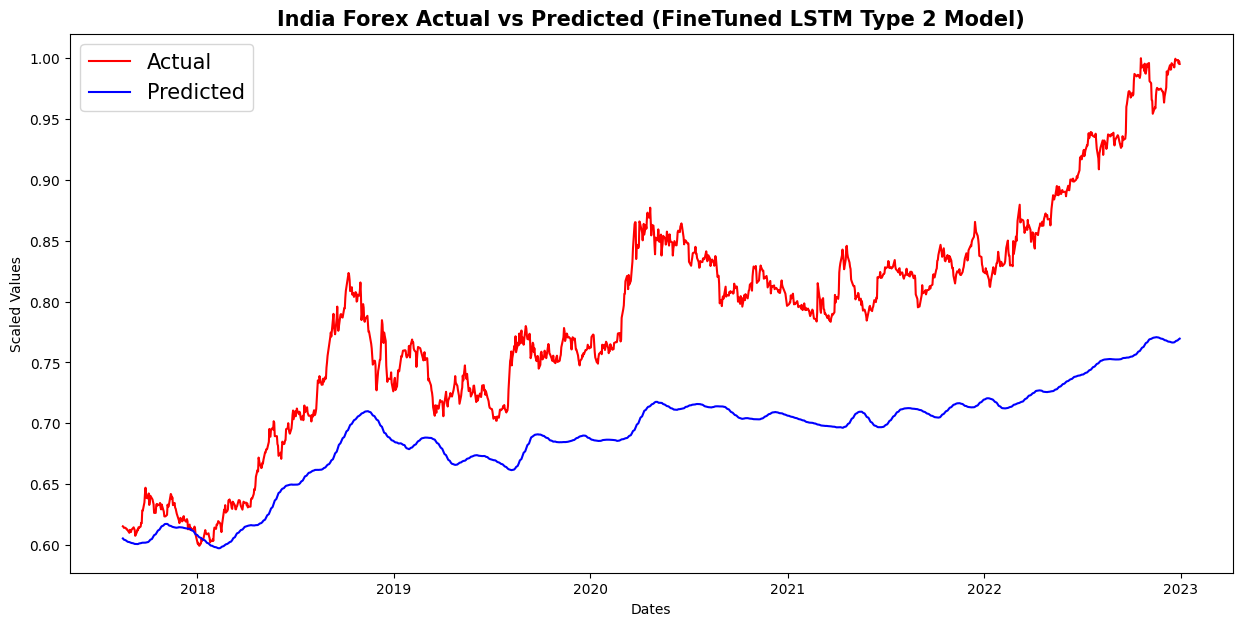

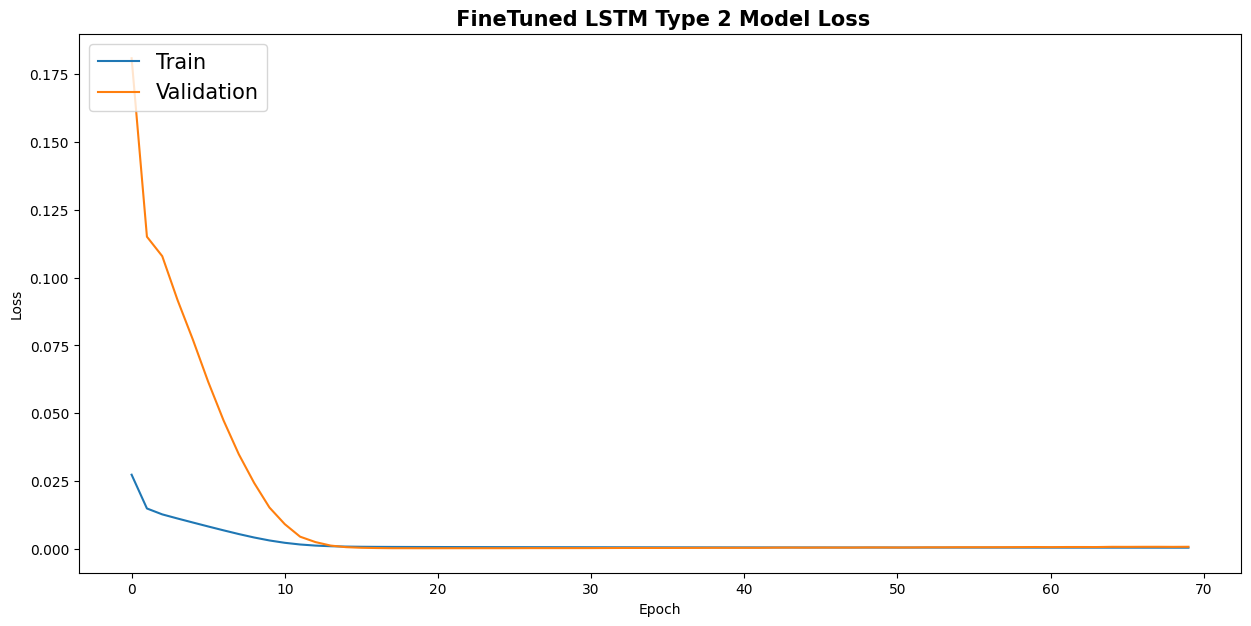

In [ ]:
lstm_pre_2 = generate_pretrain_finetune_evaluate_lstm(train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y,  "FineTuned LSTM Type 2")

## Method 3
###  Not using India's data in Pre-Training and  using complete India's data in Fine Tuning

In [11]:
train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y = generate_data_for_pretrain(final_df, 30, 3)

1000	2000	3000	4000	5000	6000	7000	

### Generating Pretrained Model, FineTuning and Evaluating RNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 512)           265216    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 256)           196864    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 30, 256)           131328    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 642817 (2.45 MB)
Trainable params: 49409 (193.00 KB)
Non-trainable params: 593408 (2.26 MB)
_________________________________________________________________
None
Epoch 1/70


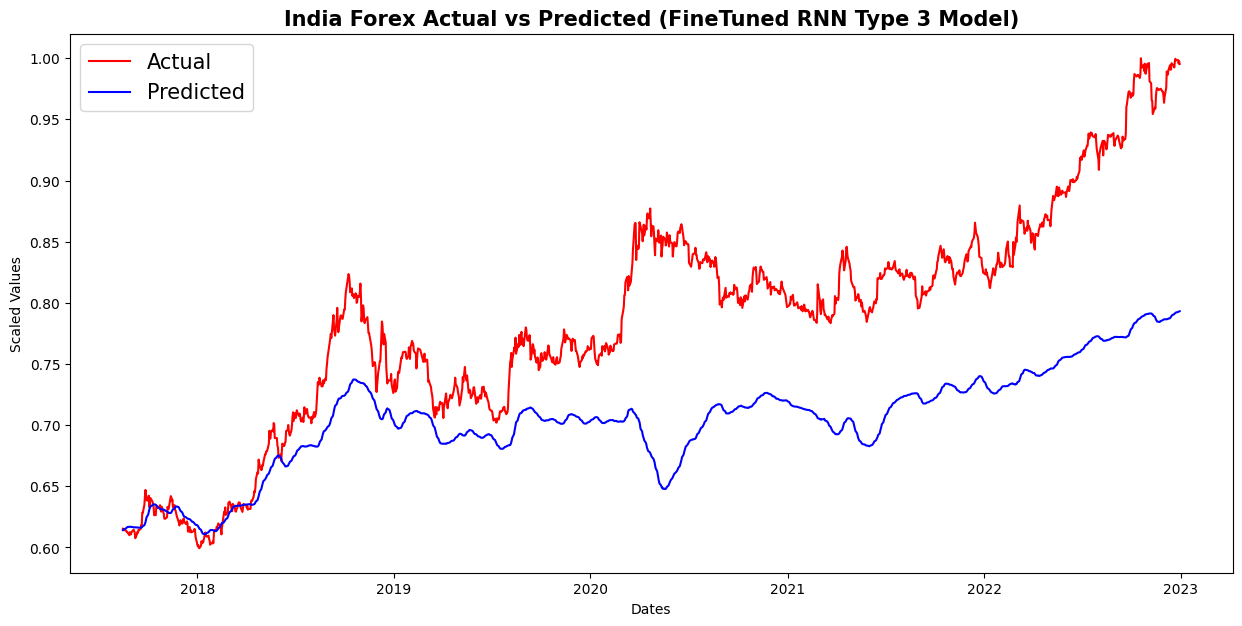

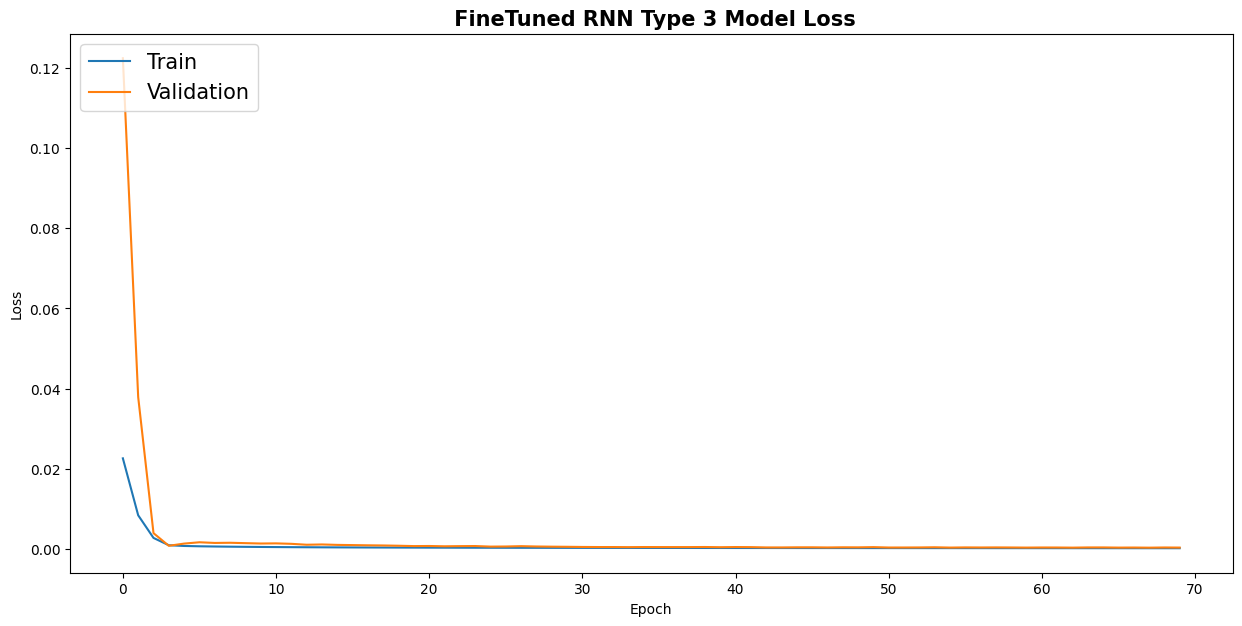

In [22]:
rnn_pre_3 = generate_pretrain_finetune_evaluate_rnn(train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y, "FineTuned RNN Type 3")

### Generating Pretrained Model, FineTuning and Evaluating LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 512)           1060864   
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           787456    
                                                                 
 lstm_2 (LSTM)               (None, 30, 256)           525312    
                                                                 
 lstm_4 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2570881 (9.81 MB)
Trainable params: 197249 (770.50 KB)
Non-trainable params: 2373632 (9.05 MB)
_________________________________________________________________
None
Epoch 1/

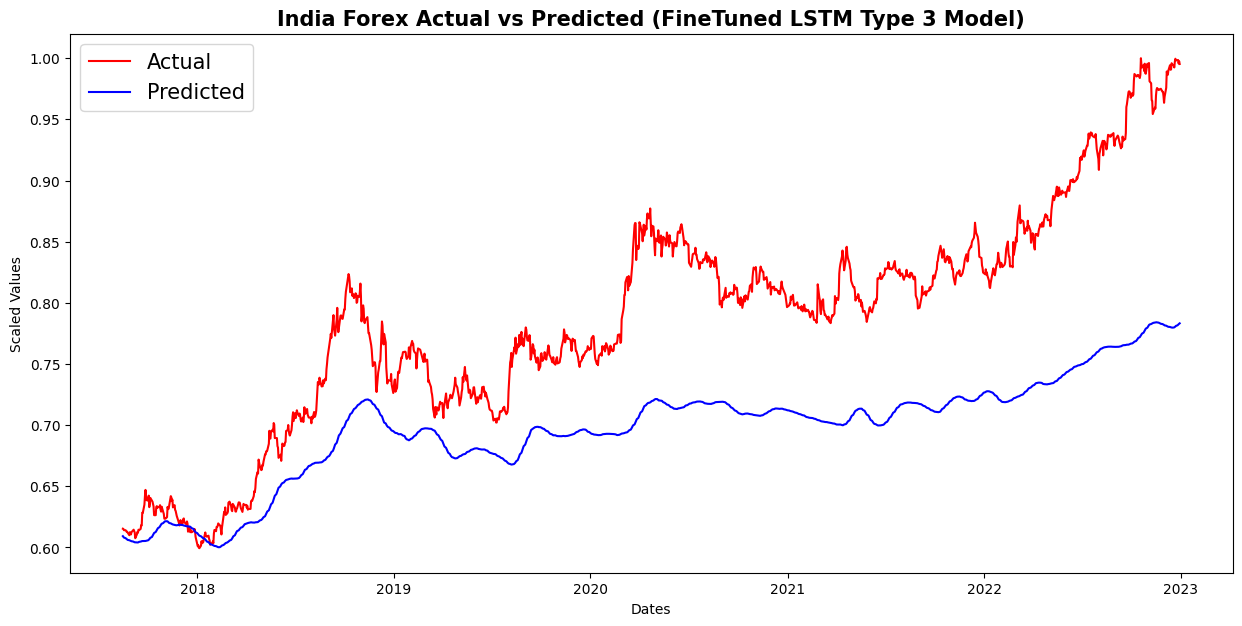

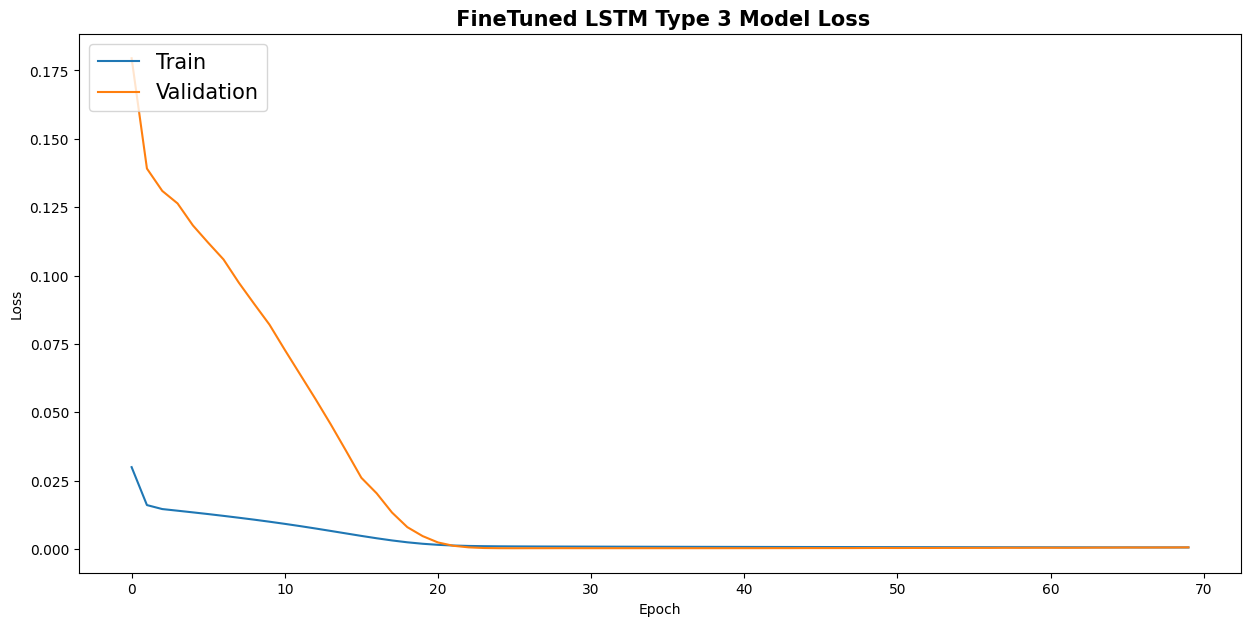

In [12]:
lstm_pre_3 = generate_pretrain_finetune_evaluate_lstm(train_X, train_Y, val_X, val_Y, test_x, test_y, \
            fine_tune_train_X, fine_tune_train_Y, fine_tune_val_X, \
            fine_tune_val_Y, fine_tune_test_X, fine_tune_test_Y,  "FineTuned LSTM Type 3")

# Hyper-Parameter Tuning of Best model

In [12]:
def build_model(hp):
    model = load_model('/content/gdrive/MyDrive/Forex/best_model.h5')
    model.pop()
    model.pop()
    for layer in model.layers:
        layer.trainable = False

    lstm_acti = hp.Choice('LSTM_activation',values=['relu', 'sigmoid', 'swish'])


    for i in range(hp.Int('n_layers', 0, 2)):
        model.add(LSTM( hp.Int(name=f'lstm_{i}_layer', min_value = 128, max_value = 256, step = 32),name=f'lstm_{i}_layer',
                       activation = lstm_acti,
                       return_sequences=True))

    model.add(LSTM(hp.Int('Last_lstm_layer', min_value = 128, max_value = 256, step = 32),name=f'lstm_last',
                   activation = lstm_acti,
                   return_sequences = False))

    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'], default = 'sigmoid')))

    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam', 'Adadelta'])
    hp_lr = hp.Float('learning_rate', 0.01, 0.1, step=0.02)

    if hp_optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp_lr)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_lr)
    elif hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_lr)
    elif hp_optimizer == 'Adadelta':
        optimizer = Adadelta(learning_rate=hp_lr)

    model.compile(loss='mean_squared_error', optimizer=hp_optimizer, metrics = ['mse'])
    return model

def save_best_model(model):
    model.save('/content/gdrive/MyDrive/Forex/best_model.h5')

def run_hyperparameter_tuning(model):
    #save_best_model(model)
    print("starting tuner")
    tuner= kt.RandomSearch(build_model, objective = 'mse', max_trials = 25, executions_per_trial = 2)

    es = EarlyStopping(monitor="val_loss", patience = 5, restore_best_weights = False)

    history = tuner.search(x = fine_tune_train_X, y = fine_tune_train_Y, epochs = 50, batch_size = 500,
                 validation_data = (fine_tune_val_X, fine_tune_val_Y), callbacks=[es])

    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model, history

In [17]:
best_model, history_best = run_hyperparameter_tuning("lstm_pre_3")

Trial 25 Complete [00h 00m 31s]
mse: 0.03874729173548985

Best mse So Far: 0.00037767701724078506
Total elapsed time: 00h 32m 40s


In [23]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 512)           1060864   
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           787456    
                                                                 
 lstm_2 (LSTM)               (None, 30, 256)           525312    
                                                                 
 lstm_0_layer (LSTM)         (None, 30, 224)           430976    
                                                                 
 lstm_1_layer (LSTM)         (None, 30, 224)           402304    
                                                                 
 lstm_last (LSTM)            (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 1)                

In [30]:
config = best_model.get_config()

In [42]:
for ind, i in enumerate(config['layers']):
  if ind == 0:
    continue
  cur_conf = i['config']
  print("For Layer %s" % ind)
  #print(cur_conf)
  print("Layer = ", cur_conf["name"], "\tIs Trainable = ", cur_conf["trainable"], "\tActivation = ",cur_conf["activation"])
  print()

For Layer 1
Layer =  lstm 	Is Trainable =  False 	Activation =  tanh

For Layer 2
Layer =  lstm_1 	Is Trainable =  False 	Activation =  tanh

For Layer 3
Layer =  lstm_2 	Is Trainable =  False 	Activation =  tanh

For Layer 4
Layer =  lstm_0_layer 	Is Trainable =  True 	Activation =  swish

For Layer 5
Layer =  lstm_1_layer 	Is Trainable =  True 	Activation =  swish

For Layer 6
Layer =  lstm_last 	Is Trainable =  True 	Activation =  swish

For Layer 7
Layer =  dense 	Is Trainable =  True 	Activation =  sigmoid



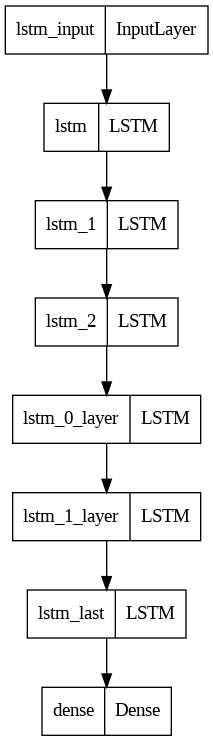

In [29]:
plot_model(best_model, "/content/gdrive/MyDrive/Forex/model_graph.png")

In [18]:
best_model.save('/content/gdrive/MyDrive/Forex/Hyp_Tuned_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The model performance for Hyper Parameter & Fine Tuned LSTM Model on Test set
--------------------------------------
MAE is 0.05953244864940643
MSE is 0.004670246969908476
R2 score is 0.4466207755277226


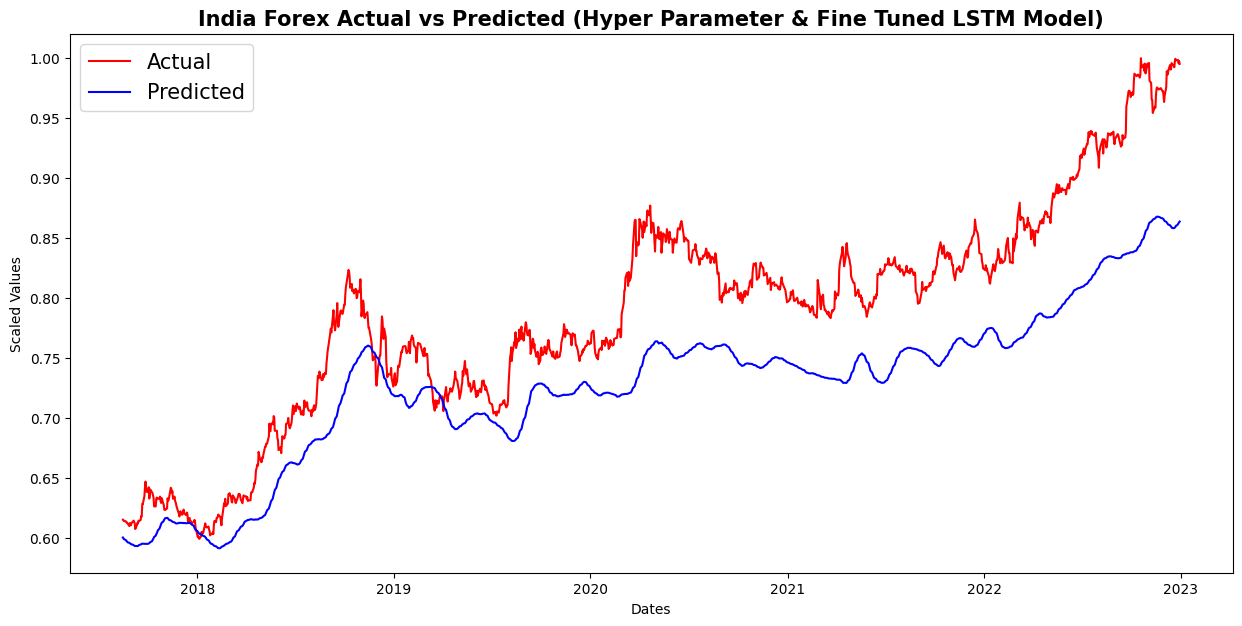

In [19]:
evaluate_model_performance(best_model,  fine_tune_test_X, fine_tune_test_Y, scaled_df, "Hyper Parameter & Fine Tuned LSTM")

In [5]:
tp = load_model('/content/gdrive/MyDrive/Forex/Hyp_Tuned_model.h5')

In [6]:
tp.optimizer